# Tutorial 2: Variational Trajectory Planning - Build a motion planner and upload benchmark solutions

This tutorial shows how you can plan trajectories in CommonRoad scenarios by solving an optimization problem and easily create a benchmark solution file for upload the solution to <a href="https://commonroad.in.tum.de/new-submission"> commonroad.in.tum.de</a>. We therefore use the CommonRoad scenario 'ZAM_Tutorial-1_2_T-1.xml' which was created in Tutorial 1.

## Task of the Ego Vehicle

The ego vehicle has the following specification in our scenario:
- obstacle type: car
- obstacle shape: rectangle with a width of 1.844m and a length of 4.569m as prescribed in <a href="https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/-/blob/master/PYTHON/vehiclemodels/parameters_vehicle3.py">VW Vanagon, Vehicle Type 3</a> (see also  <a href="https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/blob/master/vehicleModels_commonRoad.pdf">documentation vehicle models</a>)
- initial state:
    - position: (15, 0.0) m
    - orientation: 0.00 rad
    - velocity: 22 m/s
- ID in ZAM_Tutorial-1_2_T-1.xml: 100

The following physical constraints apply to the ego vehicle:
- minimum acceleration: -6 m/s2
- maximum acceleration: 15 m/s2
- minimum jerk: -15 m/s3
- maximum jerk: 15 m/s3

The task of the ego vehicle is to reach its target velocity of 30.0 m/s without colliding with other obstacles. 


# Exercise 0: Read the created CommonRoad scenario

The CommonRoadFileReader reads the Scenario and the PlanningProblemSet from a CommonRoad XML-file. Please read the scenario from the CommonRoad file.

In [1]:
from __future__ import annotations

import os
from dataclasses import dataclass
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from cvxpy import Constraint, Minimize, Objective, Problem, Variable, quad_form
from vehiclemodels import parameters_vehicle3

from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.geometry.shape import Rectangle
from commonroad.planning.planner_interface import TrajectoryPlannerInterface
from commonroad.planning.planning_problem import PlanningProblem
from commonroad.prediction.ground_truth_predictor import GroundTruthPredictor
from commonroad.prediction.prediction import TrajectoryPrediction
from commonroad.scenario.obstacle import DynamicObstacle, ObstacleType
from commonroad.scenario.scenario import Scenario
from commonroad.scenario.state import LongitudinalState, PMState
from commonroad.scenario.trajectory import Trajectory
from commonroad.visualization.draw_params import DynamicObstacleParams
from commonroad.visualization.mp_renderer import MPRenderer

%matplotlib inline
plt.rcParams["figure.max_open_warning"] = 50

# load the CommonRoad scenario that has been created in the CommonRoad tutorial
file_path = os.path.join(os.getcwd(), "ZAM_Tutorial-1_2_T-1.xml")

scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

We can plot the scenario and the planning problem set for each time step.

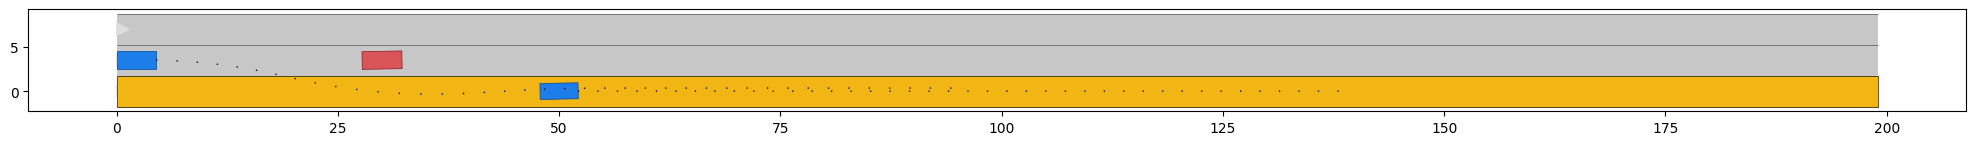

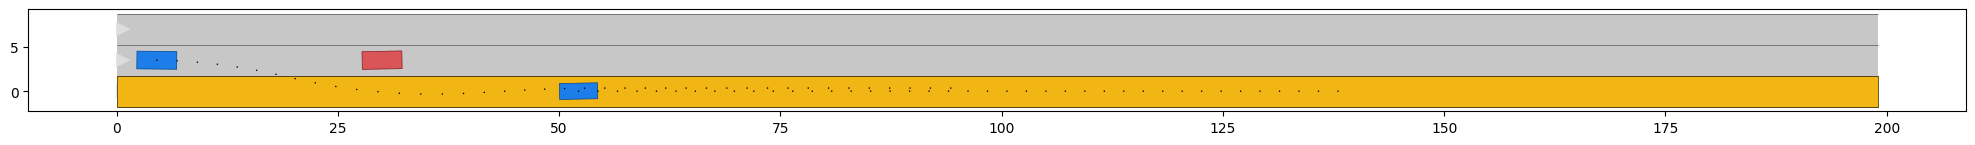

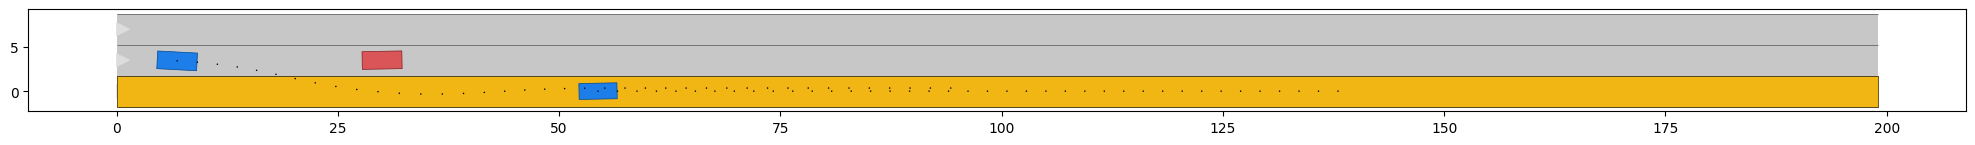

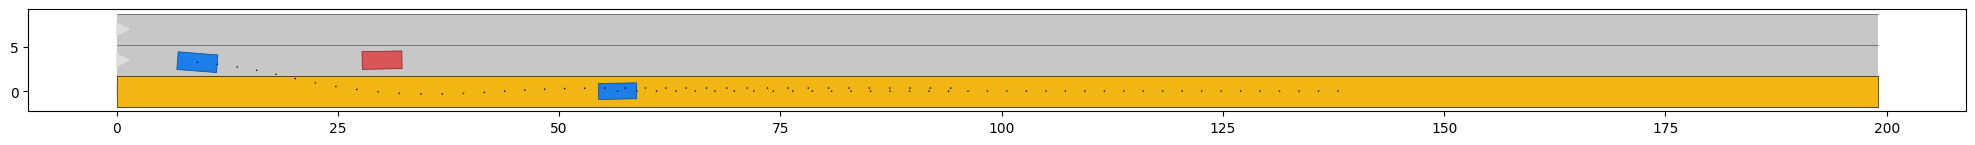

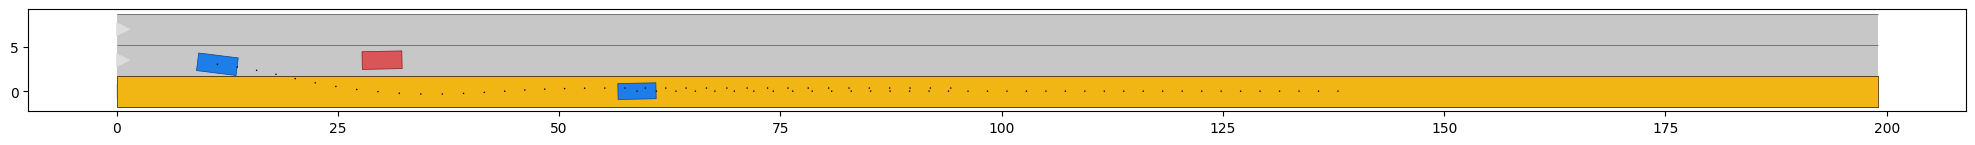

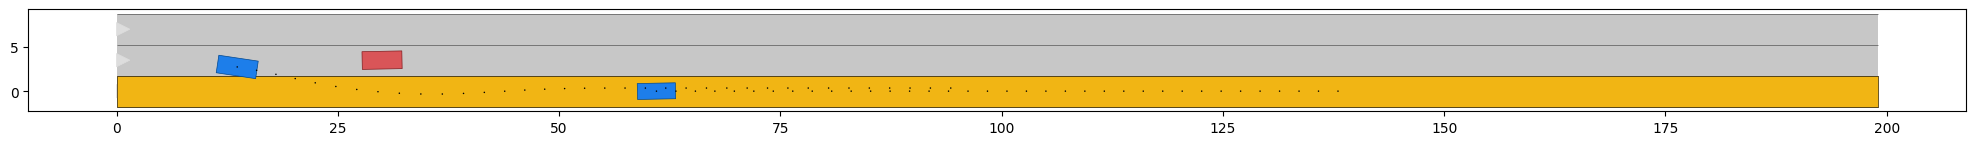

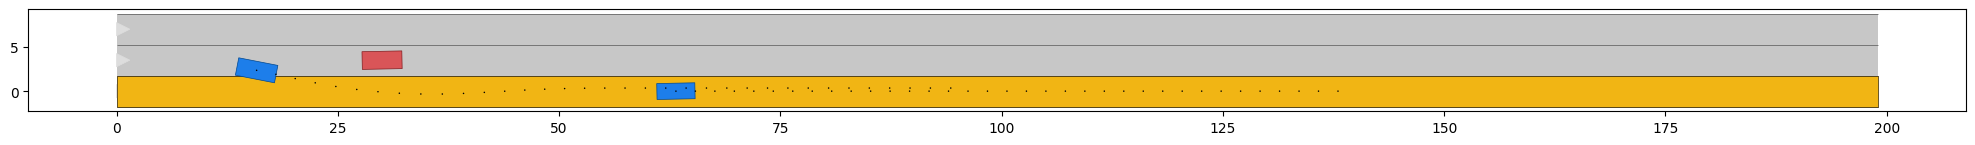

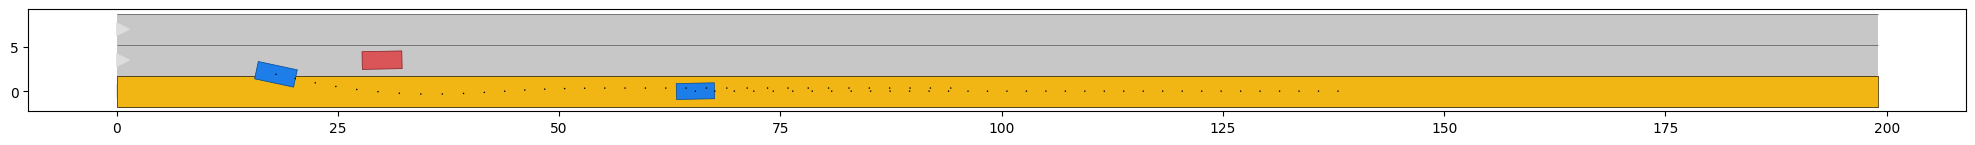

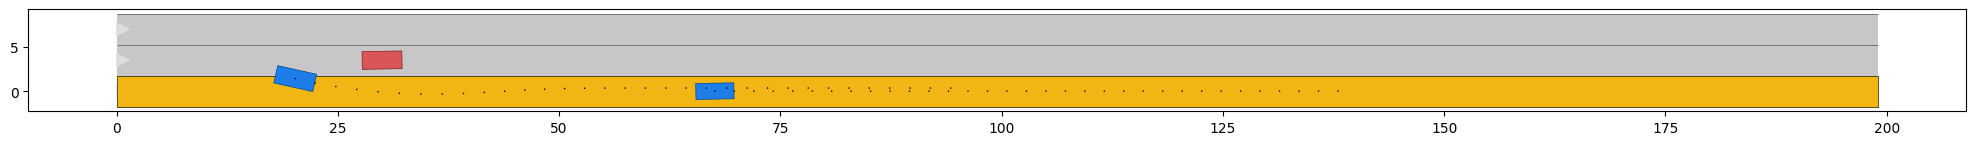

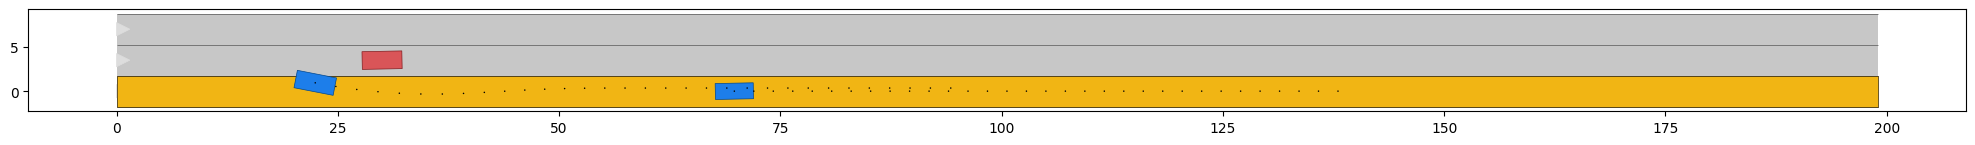

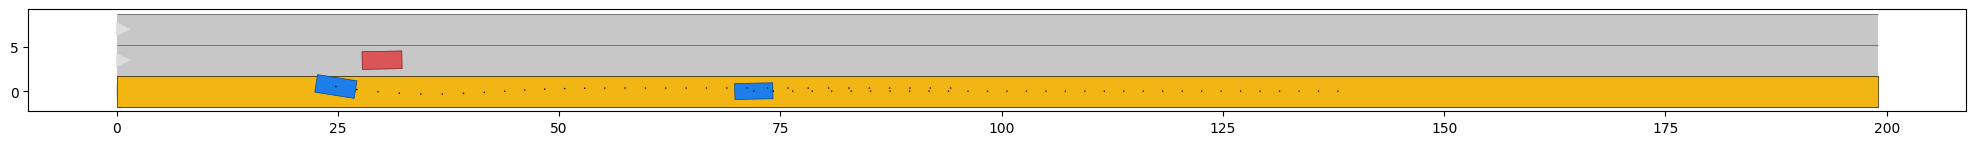

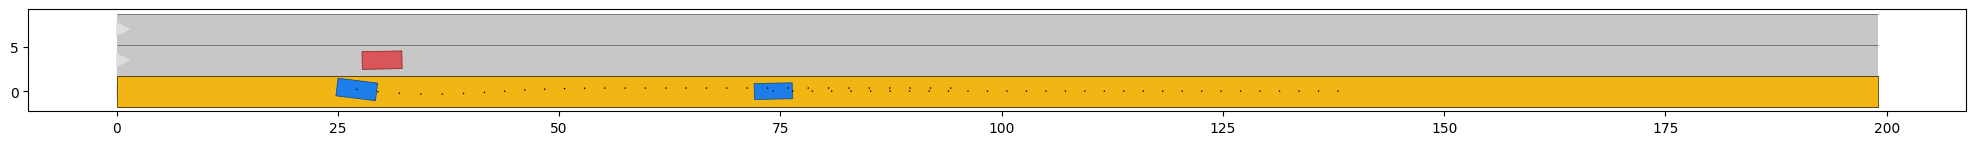

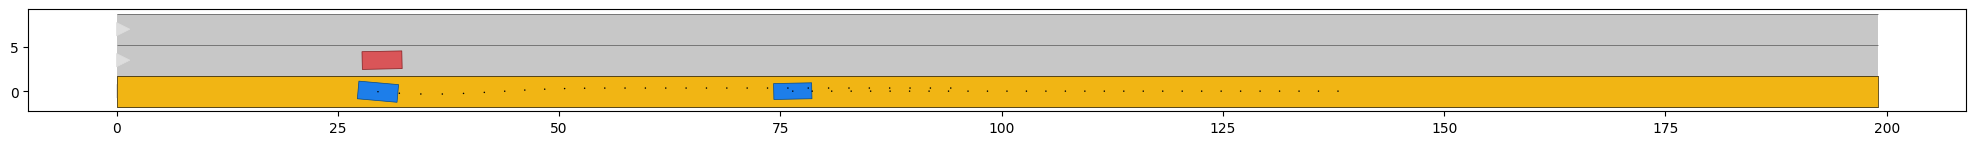

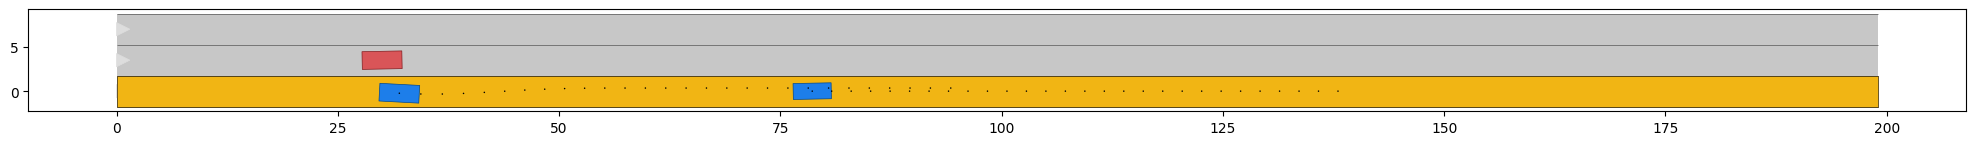

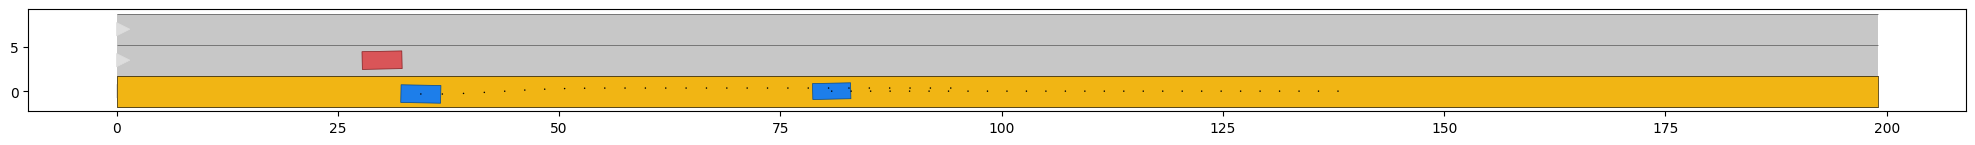

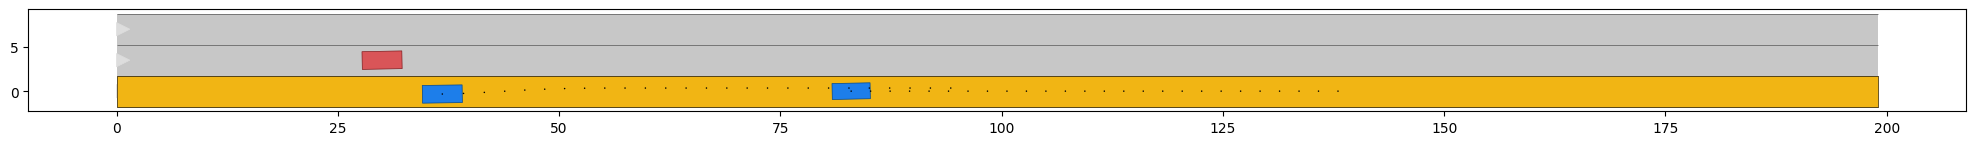

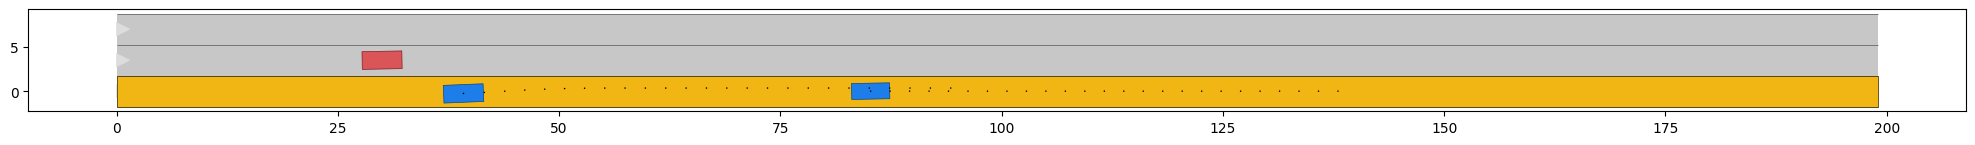

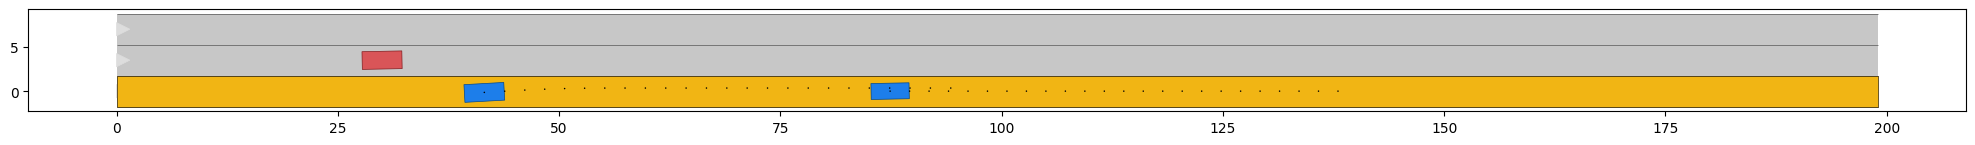

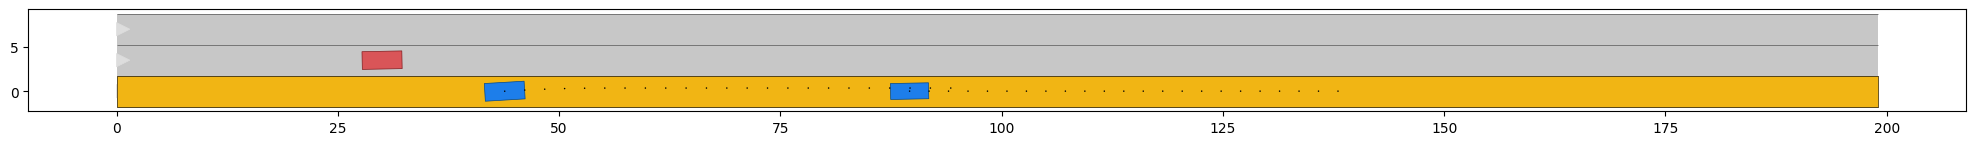

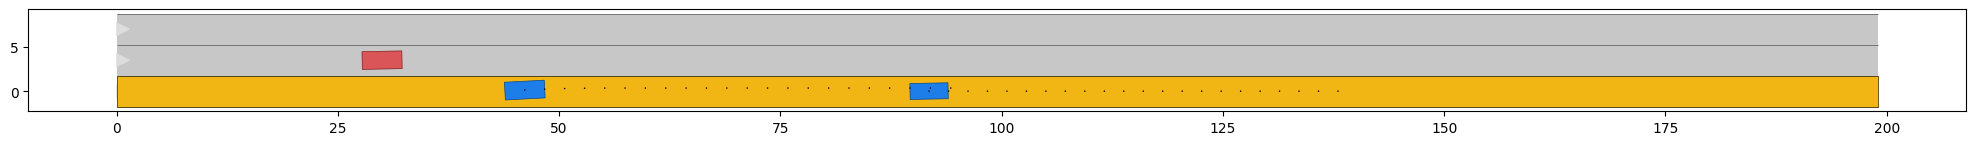

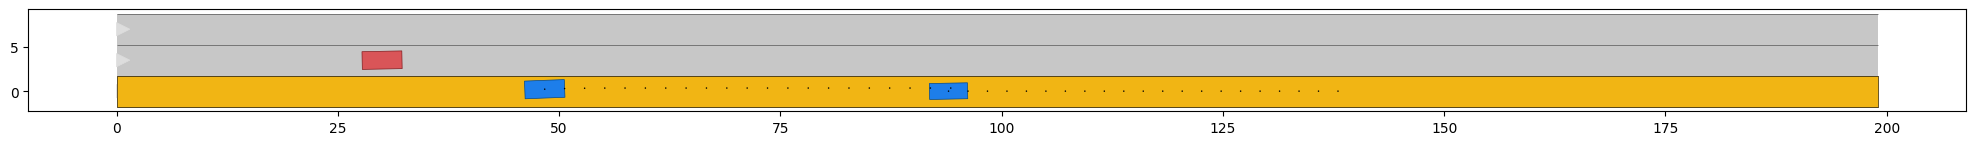

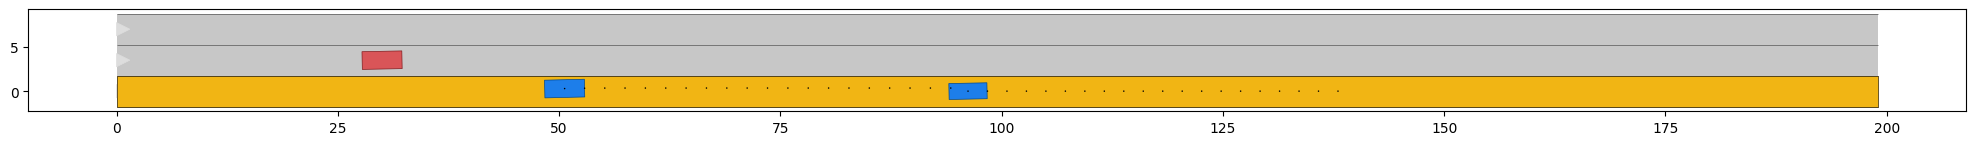

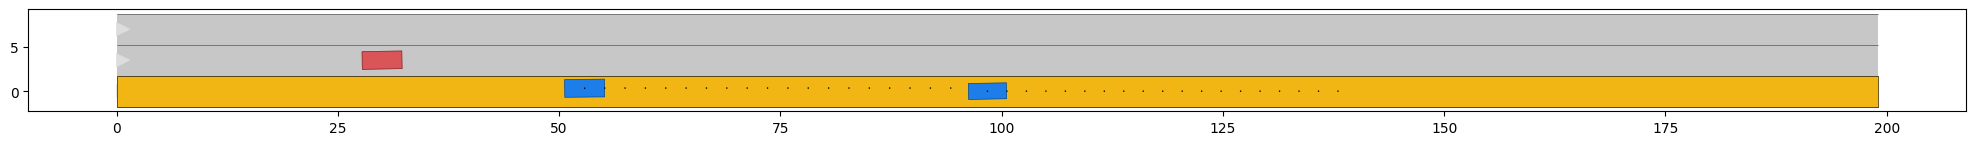

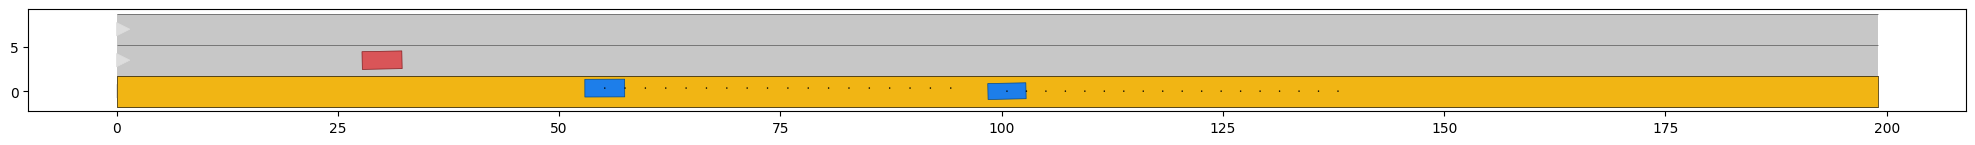

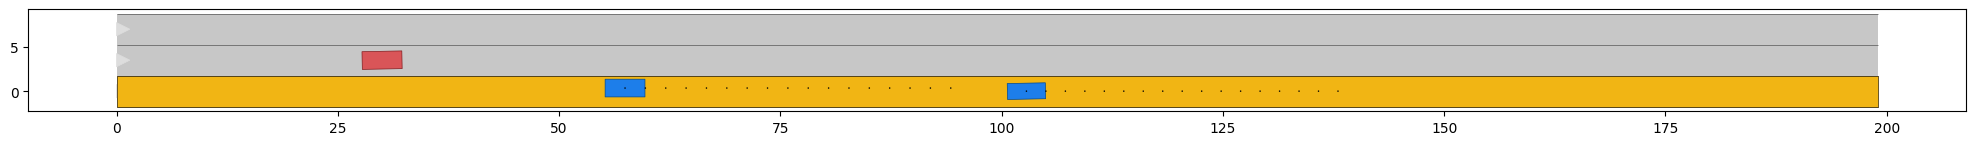

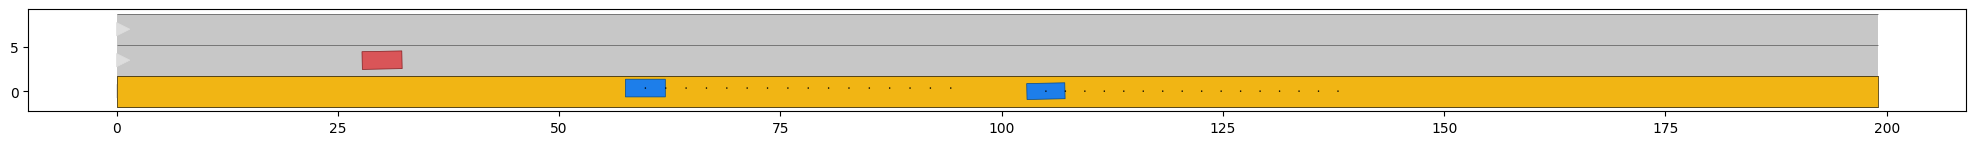

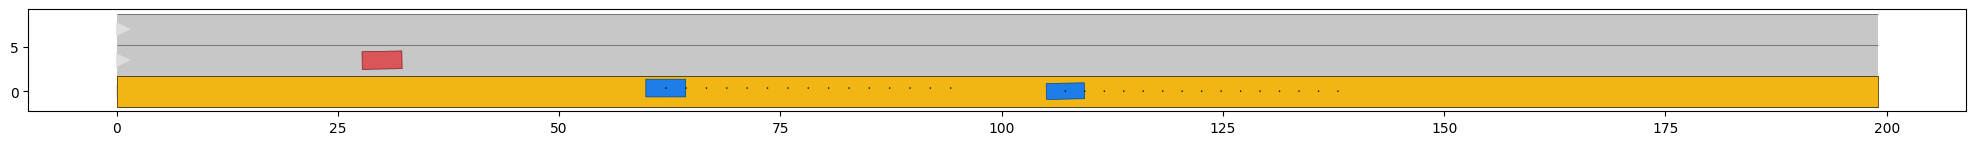

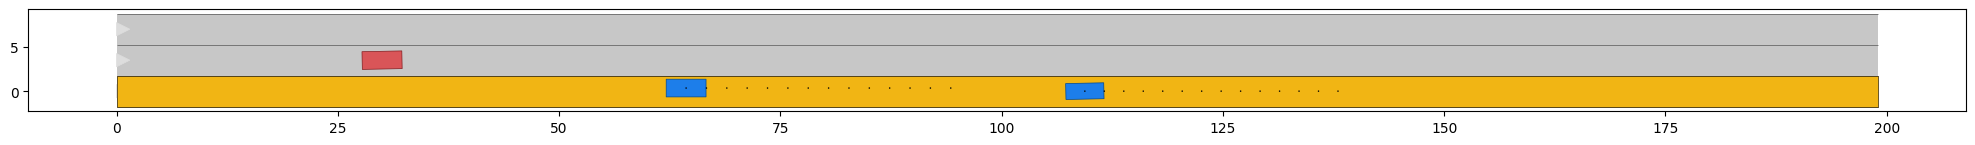

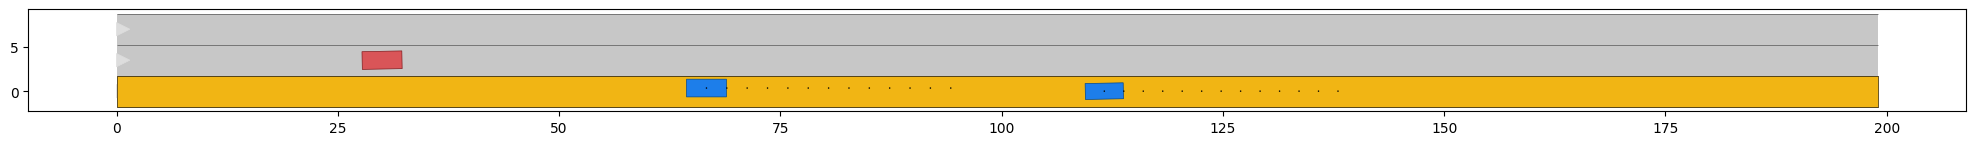

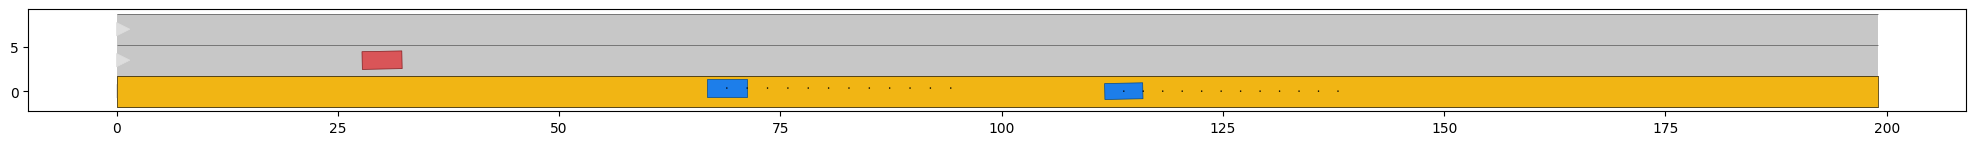

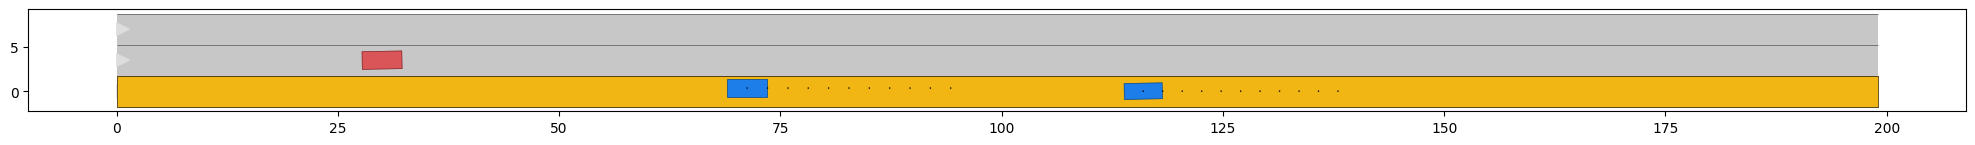

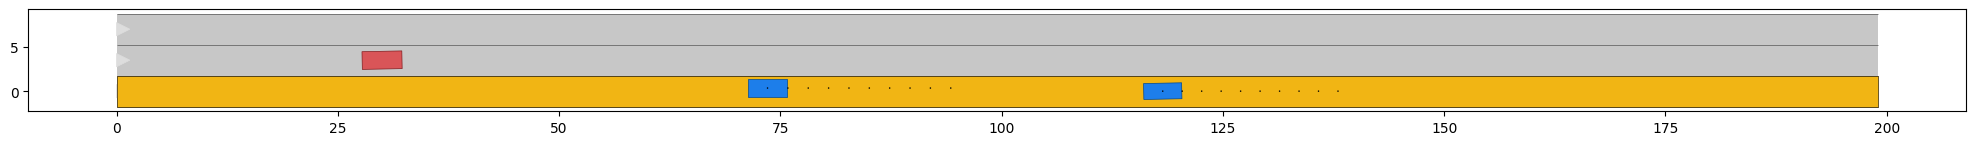

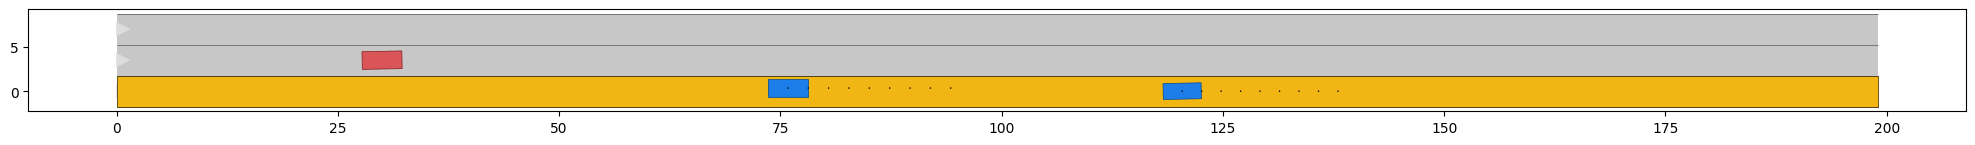

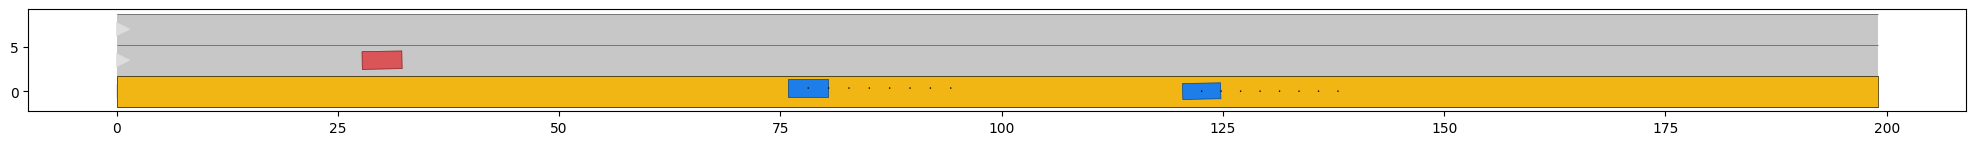

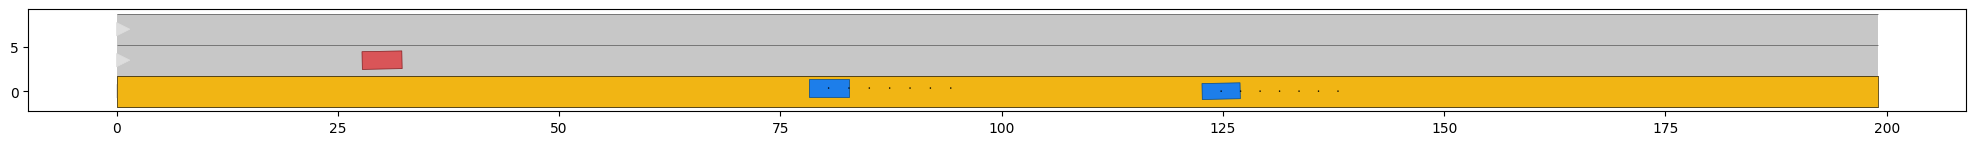

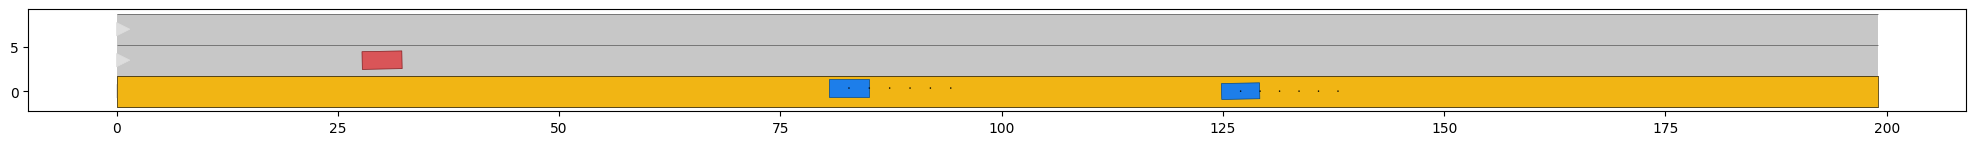

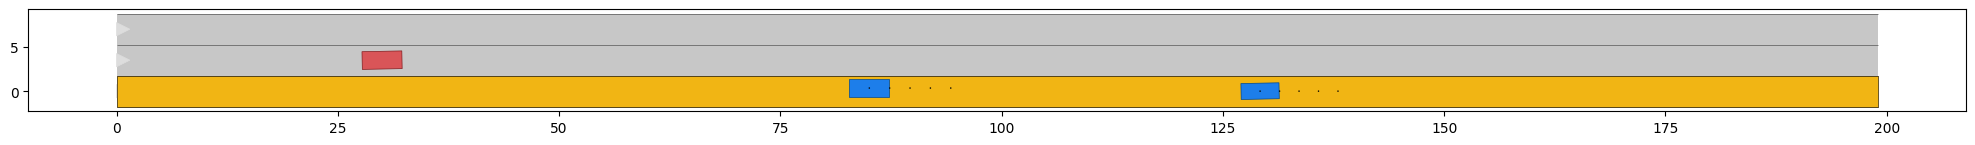

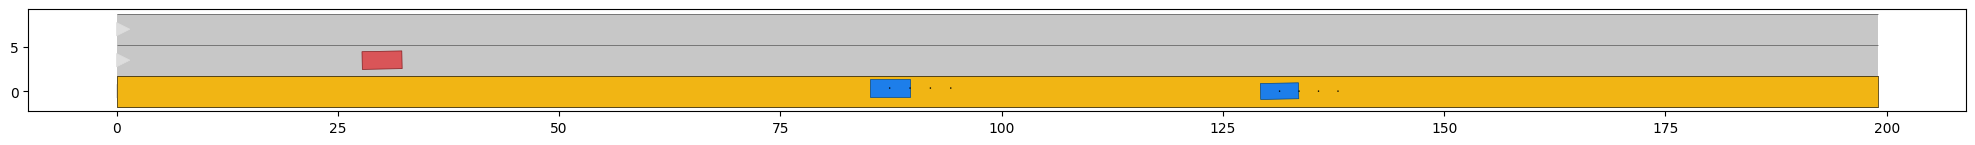

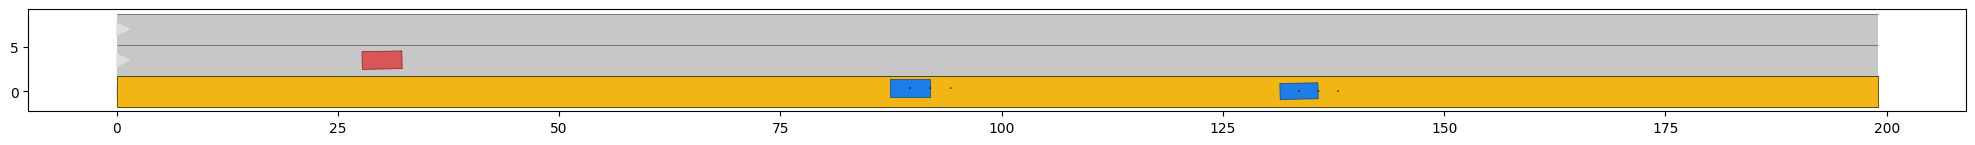

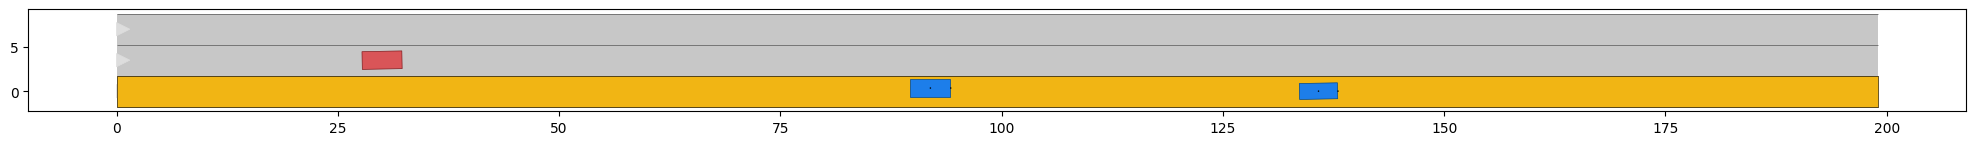

In [2]:
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    rnd.draw_params.time_begin = i
    scenario.draw(rnd)
    planning_problem_set.draw(rnd)
    rnd.render()

# Helper Function for Visualization

In [3]:
def plot_state_vector(trajectory: Trajectory, c: Optional[TIConstraints] = None, s_obj=None):
    plt.figure(figsize=(10, 10))
    k = np.arange(1, len(trajectory.state_list) + 1)

    # setup bounds
    s_min = 0
    s_max = 150
    if c:
        v_min = c.v_min
        v_max = c.v_max
        a_min = c.a_min
        a_max = c.a_max
        j_min = c.j_min
        j_max = c.j_max
    else:
        v_min = 0
        v_max = 35
        a_min = -8
        a_max = 15
        j_min = -30
        j_max = 30

    # Plot (x_t)_1.
    plt.subplot(4, 1, 1)
    x1 = np.array([s.longitudinal_position for s in trajectory.state_list])
    plt.plot(k, x1, "g")
    if s_obj is not None:
        plt.plot(k, s_obj[0], "b")
        plt.plot(k, s_obj[1], "r")
    plt.ylabel(r"$s$", fontsize=16)
    plt.yticks(np.linspace(s_min, s_max, 3))
    plt.ylim([s_min, s_max])
    plt.xticks([])

    # Plot (x_t)_2.
    plt.subplot(4, 1, 2)
    x2 = np.array([s.velocity for s in trajectory.state_list])
    plt.plot(k, x2, "g")
    plt.yticks(np.linspace(v_min, v_max, 3))
    plt.ylim([v_min, v_max + 2])
    plt.ylabel(r"$v$", fontsize=16)
    plt.xticks([])

    # Plot (x_t)_3.
    plt.subplot(4, 1, 3)
    x2 = np.array([s.acceleration for s in trajectory.state_list])
    plt.plot(k, x2, "g")
    plt.yticks(np.linspace(a_min, a_max, 3))
    plt.ylim([a_min, a_max + 2])
    plt.ylabel(r"$a$", fontsize=16)
    plt.xticks([])

    # Plot (x_t)_4.
    plt.subplot(4, 1, 4)
    x2 = np.array([s.jerk for s in trajectory.state_list])
    plt.plot(k, x2, "g")
    plt.yticks(np.linspace(j_min, j_max, 3))
    plt.ylim([j_min - 1, j_max + 1])
    plt.ylabel(r"$j$", fontsize=16)
    plt.xticks(np.arange(0, len(trajectory.state_list) + 1, 5))
    plt.xlabel(r"$k$", fontsize=16)
    plt.tight_layout()
    plt.show()

# Exercise 1: Consider the vehicle model

In order to obtain kinematically feasible motion plans, the optimization problem needs to respect the constraints of the vehicle model. We use a linear vehicle model, which can be written in the following state-space form: $$x_{k+1} = A x_k + B u_k.$$ Please fill the matrices A and B according to the fourth-order point-mass model, discretized using the time step dT.

In [4]:
def vehicle_model(dT: float) -> Tuple[np.ndarray, np.ndarray]:
    A = np.array(
        [[1, dT, (dT**2) / 2, (dT**3) / 6], [0, 1, dT, (dT**2) / 2], [0, 0, 1, dT], [0, 0, 0, 1]]
    )
    B = np.array([(dT**4) / 24, (dT**3) / 6, (dT**2) / 2, dT]).reshape(
        [
            4,
        ]
    )
    return A, B

## Formulation of the Optimization Problem

Using the trajectory planner interface of CommonRoad, we want to create a motion planner based on convex optimization.
The `plan` method expects a scenario and a planning problem (and optionally a reference path) and returns a trajectory.
We use the convex optimization package cvxpy to formulate our optimization problem.
First, we create variables for the state and input vector.
Subsequently, we set up the vehicle model constraints and the cost function.
Finally, we solve the optimization problem and return the planned trajectory.

In [5]:
# dataclass for weights in cost function
@dataclass(frozen=True, kw_only=True)
class CostWeights:
    w_s: float  # weight for position
    w_v: float  # weight for velocity
    w_a: float  # weight for acceleration
    w_j: float  # weight for jerk
    w_u: float  # weight for input

In [6]:
@dataclass(frozen=True, kw_only=True)
class PlanningContext:
    scenario: Scenario
    planning_problem: PlanningProblem
    v_ref: float
    A: np.ndarray
    B: np.ndarray
    x: Variable
    u: Variable


class VehicleModelPlanner(TrajectoryPlannerInterface):
    Q: np.ndarray  # cost matrix for state
    R: float  # cost for input
    N: int  # number of time steps to plan

    _prob: Optional[Problem] = None

    def __init__(self, weights: CostWeights, N: int):
        self.Q = np.diag([weights.w_s, weights.w_v, weights.w_a, weights.w_j])
        self.R = weights.w_u
        self.N = N

    @property
    def last_computation_time(self) -> Optional[float]:
        return self._prob.solver_stats.solve_time

    def _setup_vehicle_model_constraints(self, ctx: PlanningContext) -> List[Constraint]:
        # initial state of vehicle for the optimization problem (longitudinal position, velocity, acceleration, jerk)
        pp = ctx.planning_problem
        x_0 = np.array([pp.initial_state.position[0], pp.initial_state.velocity, 0.0, 0.0]).reshape(
            [
                ctx.A.shape[0],
            ]
        )  # initial state

        # initial state constraint
        constraints = [ctx.x[:, 0] == x_0]
        # time variant state and input constraints
        constraints += [
            ctx.x[:, k + 1] == ctx.A @ ctx.x[:, k] + ctx.B * ctx.u[k] for k in range(self.N)
        ]
        return constraints

    def _setup_cost(self, ctx: PlanningContext) -> Objective:
        # cost function
        cost = 0
        for k in range(self.N):
            cost += (
                quad_form(
                    ctx.x[:, k + 1]
                    - np.array(
                        [0, ctx.v_ref, 0, 0],
                    ),
                    self.Q,
                )
                + self.R * ctx.u[k] ** 2
            )
        return cost

    def _get_constraints_and_cost(self, ctx: PlanningContext) -> Tuple[List[Constraint], Objective]:
        # setup constraints and cost function
        constr = self._setup_vehicle_model_constraints(ctx)
        cost = self._setup_cost(ctx)

        return constr, cost

    def plan(
        self, sc: Scenario, pp: PlanningProblem, ref_path: Optional[np.ndarray] = None
    ) -> Trajectory:
        # set up vehicle model
        A, B = vehicle_model(sc.dt)
        n = A.shape[0]

        # set up variables
        x = Variable(shape=(n, self.N + 1))  # optimization vector x contains n states per time step
        u = Variable(shape=self.N)  # optimization vector u contains 1 state
        # reference velocity
        v_ref = 30.0
        ctx = PlanningContext(
            scenario=sc,
            planning_problem=pp,
            v_ref=v_ref,
            A=A,
            B=B,
            x=x,
            u=u,
        )

        # setup constraints and cost function
        constr, cost = self._get_constraints_and_cost(ctx)

        # create optimization problem
        prob = Problem(Minimize(cost), constr)

        # Solve optimization problem
        prob.solve(verbose=True)
        print("Problem is convex: ", prob.is_dcp())
        print("Problem solution is " + prob.status)

        # Store problem for later inspection
        self._prob = prob

        # generate state list of the ego vehicle's trajectory
        state_list = [
            LongitudinalState(
                time_step=i,
                longitudinal_position=x.value[0, i],
                velocity=x.value[1, i],
                acceleration=x.value[2, i],
                jerk=x.value[3, i],
            )
            for i in range(1, self.N + 1)
        ]

        # create the planned trajectory starting at time step 1
        return Trajectory(initial_time_step=1, state_list=state_list)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 19 03:28:25 PM: Your problem has 204 variables, 41 constraints, and 0 parameters.
(CVXPY) Mar 19 03:28:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 19 03:28:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 19 03:28:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 19 03:28:25 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 19 03:28:25 PM: Compiling problem (target solver=OSQP).
(C

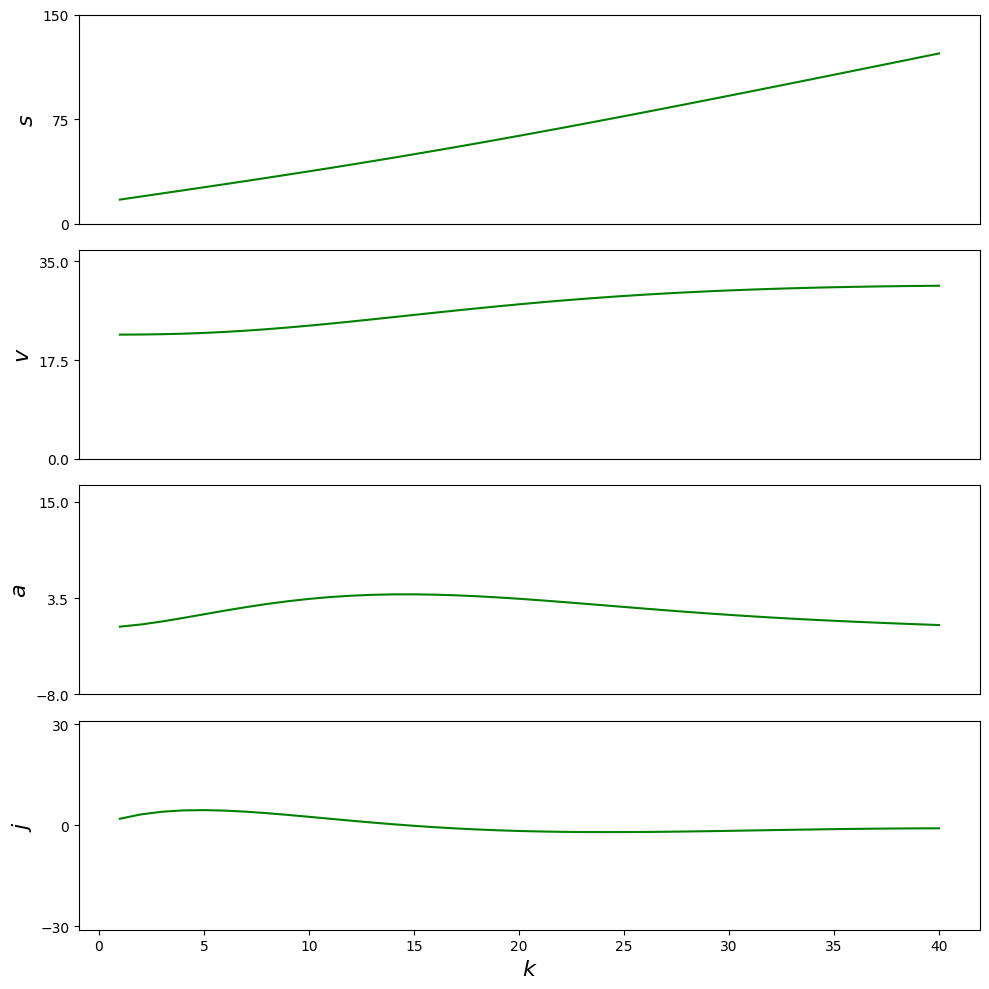

In [7]:
# plan for 40 time steps
time_steps = 40
# initialize cost function weights
weights = CostWeights(w_s=0, w_v=8, w_a=2, w_j=2, w_u=1)
# get the initial state of the ego vehicle from the planning problem set
planning_problem = planning_problem_set.find_planning_problem_by_id(100)

planner = VehicleModelPlanner(weights, time_steps)
trajectory = planner.plan(scenario, planning_problem)

# plot results
plot_state_vector(trajectory)

# Exercise 2: Consider additional constraints

The obtained trajectory reaches the desired reference velocity of the ego vehicle. However, the physical constraints are not fulfilled. Please add the physical constraints to the optimization problem in order to obtain kinematically feasible trajectories. 

In [8]:
# set up dataclass for physical constraints
@dataclass(frozen=True, kw_only=True)
class TIConstraints:
    a_min: float  # Minimum feasible acceleration of vehicle
    a_max: float  # Maximum feasible acceleration of vehicle
    v_min: float  # Minimum feasible velocity of vehicle
    v_max: float  # Maximum feasible velocity of vehicle
    j_min: float  # Minimum feasible jerk of vehicle
    j_max: float  # Maximum feasible jerk of vehicle

In [9]:
class PhysicalConstraintPlanner(VehicleModelPlanner):
    c: TIConstraints

    def __init__(self, weights: CostWeights, N: int, c: TIConstraints):
        super().__init__(weights, N)
        self.c = c

    def _setup_physical_constraints(self, ctx: PlanningContext) -> List[Constraint]:
        x = ctx.x
        tiConstraints = [x[1, :] <= self.c.v_max, x[1, :] >= self.c.v_min]  # velocity
        tiConstraints += [x[2, :] <= self.c.a_max, x[2, :] >= self.c.a_min]  # acceleration
        tiConstraints += [x[3, :] <= self.c.j_max, x[3, :] >= self.c.j_min]  # jerk
        return tiConstraints

    def _get_constraints_and_cost(self, ctx: PlanningContext) -> Tuple[List[Constraint], Objective]:
        constr, cost = super()._get_constraints_and_cost(ctx)
        constr += self._setup_physical_constraints(ctx)
        return constr, cost

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 19 03:28:26 PM: Your problem has 204 variables, 47 constraints, and 0 parameters.
(CVXPY) Mar 19 03:28:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 19 03:28:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 19 03:28:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 19 03:28:26 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 19 03:28:26 PM: Compiling problem (target solver=OSQP).
(C

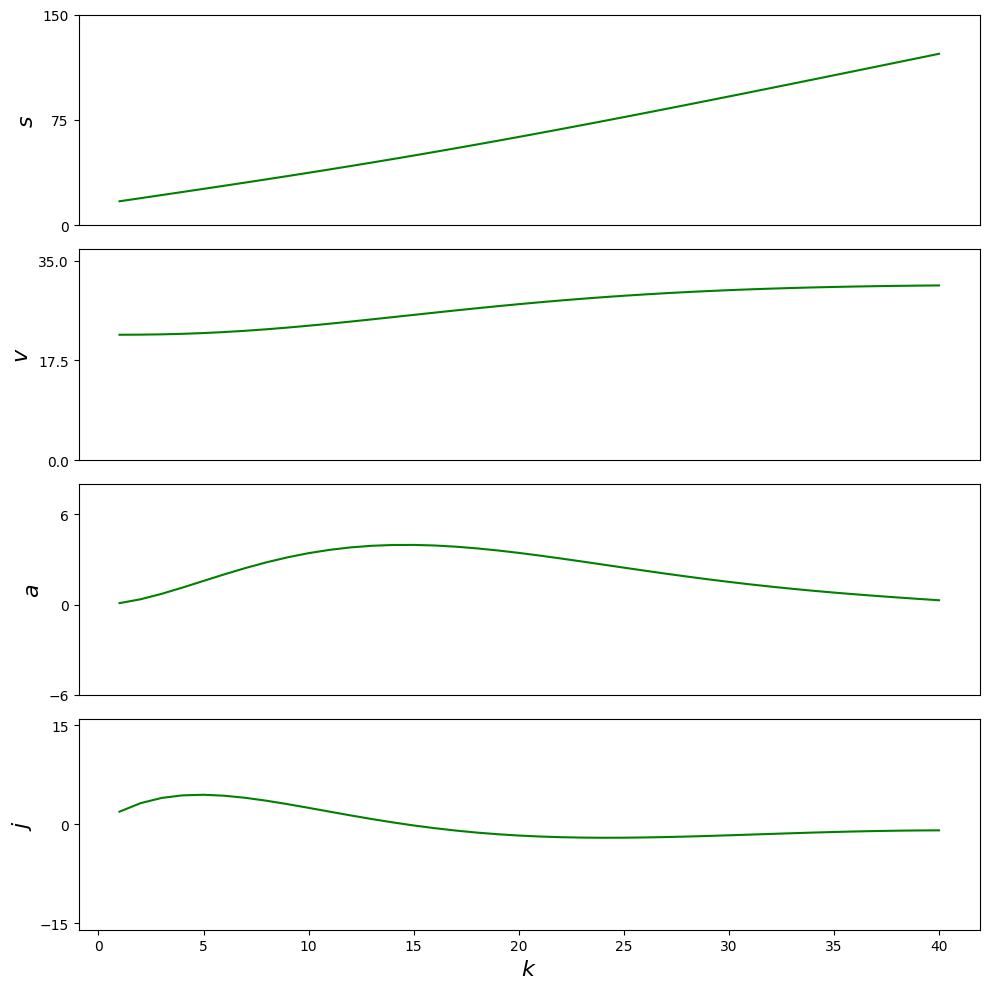

In [10]:
# initialize physical constraints
c = TIConstraints(
    a_min=-6, a_max=6, v_min=0, v_max=35, j_min=-15, j_max=15
)  # no driving backwards!  # speed limit

planner = PhysicalConstraintPlanner(weights, time_steps, c)
trajectory = planner.plan(scenario, planning_problem)

# plot results
plot_state_vector(trajectory, c)

# Exercise 3: Extract the prediction of obstacles

In our scenario, the ego vehicle is surrounded by two other traffic participants -- one following and one leading vehicle. In order to not cause a collision with these two vehicles, we need to consider the positions of the two vehicles in our optimization problem. Please obtain the minimum and maximum feasible position of the ego vehicle for each point in time. Please note that each obstacle has a certain shape.   

In [11]:
def get_obstacle_min_max_positions(
    scenario: Scenario, pp: PlanningProblem
) -> Tuple[List[float], List[float]]:
    # create constraints for minimum and maximum position
    s_min = []  # minimum position constraint
    s_max = []  # maximum position constraint

    # go through obstacle list and distinguish between following and leading vehicle
    for o in scenario.dynamic_obstacles:
        if o.initial_state.position[0] < pp.initial_state.position[0]:
            print("Following vehicle id={}".format(o.obstacle_id))
            prediction = o.prediction.trajectory.state_list
            for p in prediction:
                s_min.append(p.position[0] + o.obstacle_shape.length / 2.0 + 2.5)
        else:
            print("Leading vehicle id={}".format(o.obstacle_id))
            prediction = o.prediction.trajectory.state_list
            for p in prediction:
                s_max.append(p.position[0] - o.obstacle_shape.length / 2.0 - 2.5)

    return s_min, s_max

In order to obtain the prediction of the surrounding vehicles, we use the GroundTruthPredictor.
The GroundTruthPredictor simply uses the trajectories stored in the scenario file.

Following vehicle id=42
Leading vehicle id=44


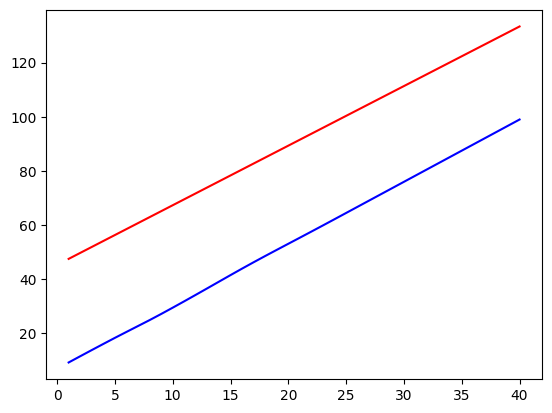

In [12]:
# predict the behavior of the surrounding vehicles (we simply use the stored prediction here)
predictor = GroundTruthPredictor()
sc_with_prediction = predictor.predict(scenario, 0)

s_min, s_max = get_obstacle_min_max_positions(sc_with_prediction, planning_problem)

# plot vehicle motions
plt.plot(range(1, len(s_min) + 1), s_min, "b")
plt.plot(range(1, len(s_max) + 1), s_max, "r")

# Exercise 4: Plan the motion of the ego vehicle

The obtained collision constraint allow us to avoid collisions with the following and leading vehicle. Please add the constraints to our optimization problem and obtain a trajectory. 

In [13]:
class ObstaclePlanner(PhysicalConstraintPlanner):
    def _setup_obstacle_constraints(self, ctx: PlanningContext) -> List[Constraint]:
        sc_with_prediction = predictor.predict(ctx.scenario, 0)
        s_min, s_max = get_obstacle_min_max_positions(sc_with_prediction, ctx.planning_problem)
        constr = [ctx.x[0, k + 1] <= s_max[k] for k in range(self.N)]  # maximum position
        constr += [ctx.x[0, k + 1] >= s_min[k] for k in range(self.N)]  # minimum position
        return constr

    def _get_constraints_and_cost(self, ctx: PlanningContext) -> Tuple[List[Constraint], Objective]:
        constr, cost = super()._get_constraints_and_cost(ctx)
        constr += self._setup_obstacle_constraints(ctx)
        return constr, cost

Following vehicle id=42
Leading vehicle id=44
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 19 03:28:26 PM: Your problem has 204 variables, 127 constraints, and 0 parameters.
(CVXPY) Mar 19 03:28:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 19 03:28:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 19 03:28:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 19 03:28:26 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 19 03:28:26

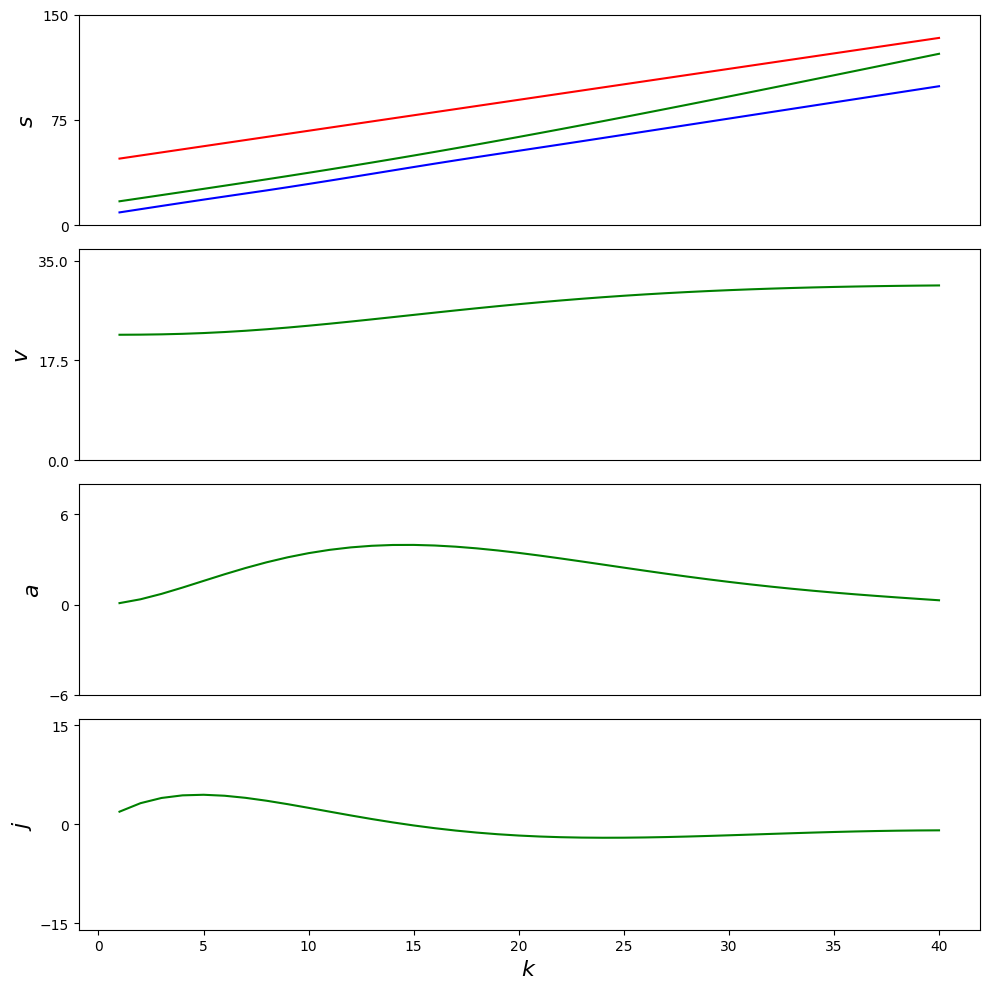

In [14]:
planner = ObstaclePlanner(weights, time_steps, c)
trajectory = planner.plan(scenario, planning_problem)

# plot results
plot_state_vector(trajectory, c, [s_min, s_max])

# Exercise 5

We have successfully planned the motion of the ego vehicle. Please convert the ego vehicle to a dynamic obstacle and visualize the scenario and the motion of the ego vehicle for each time step.

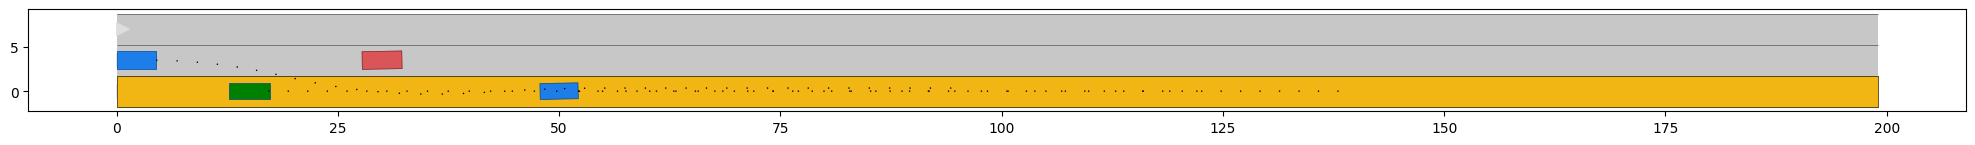

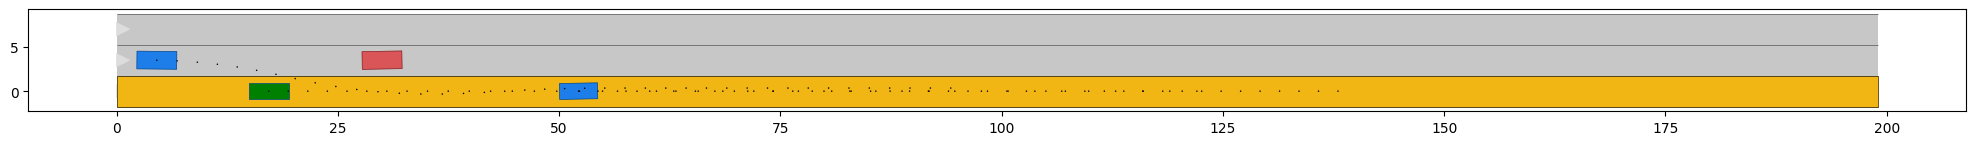

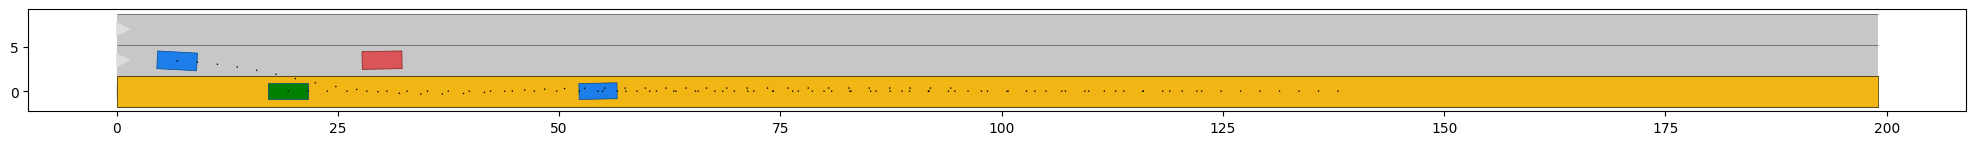

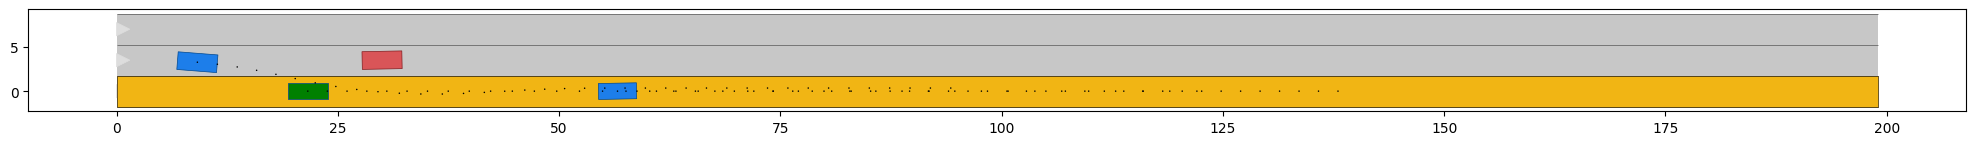

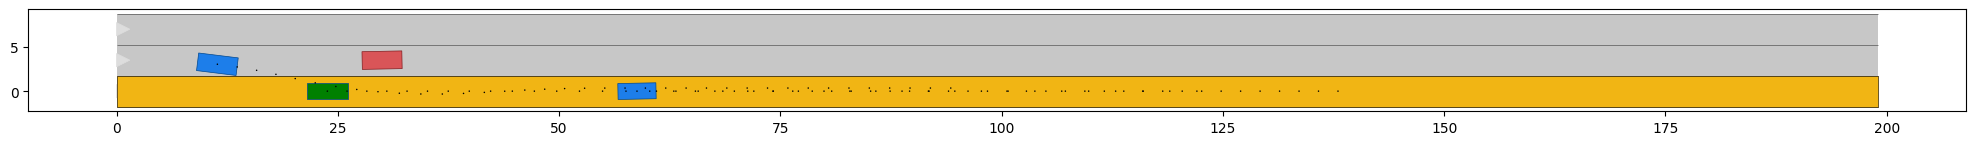

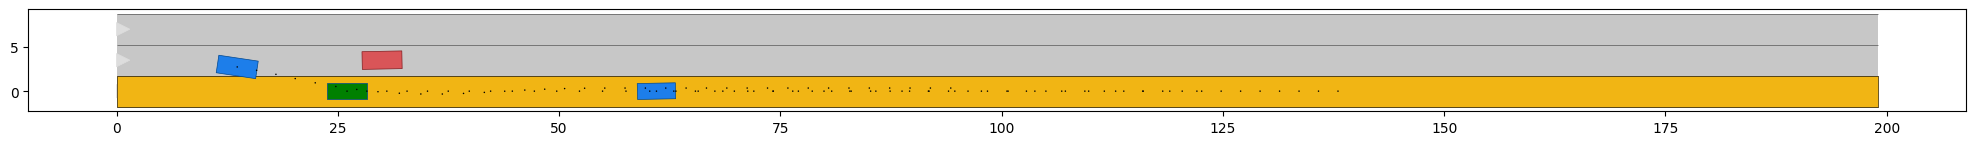

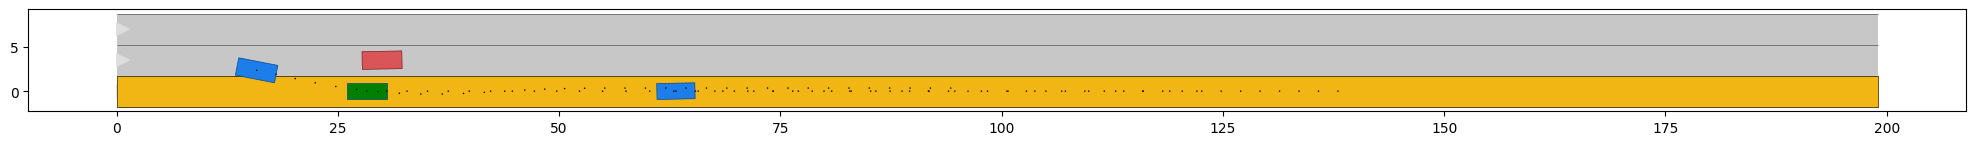

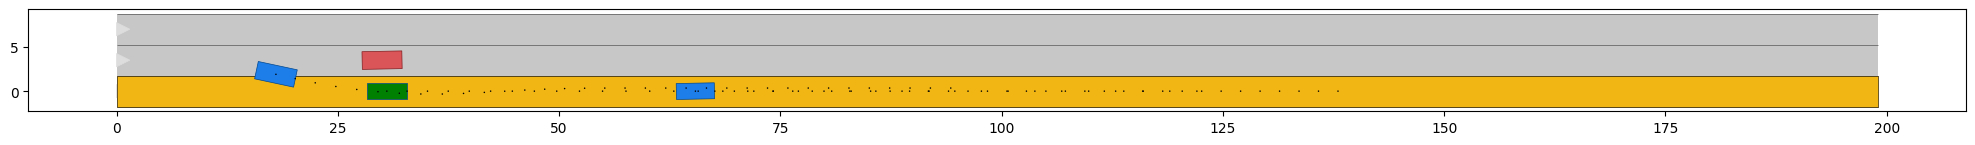

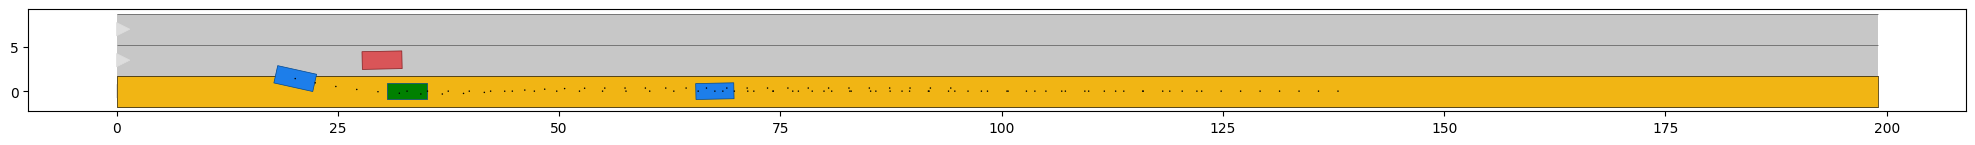

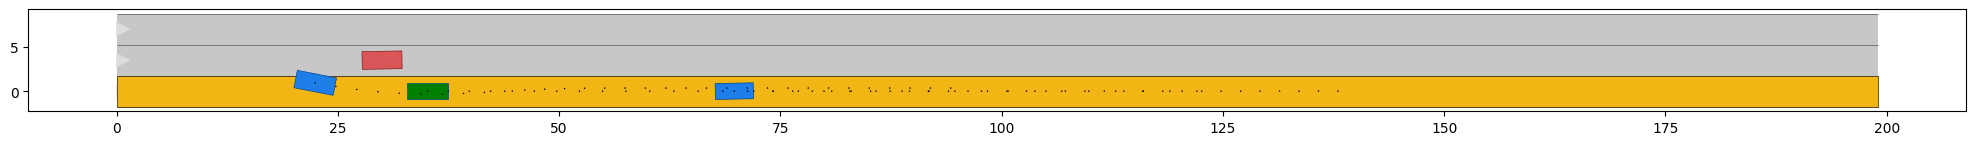

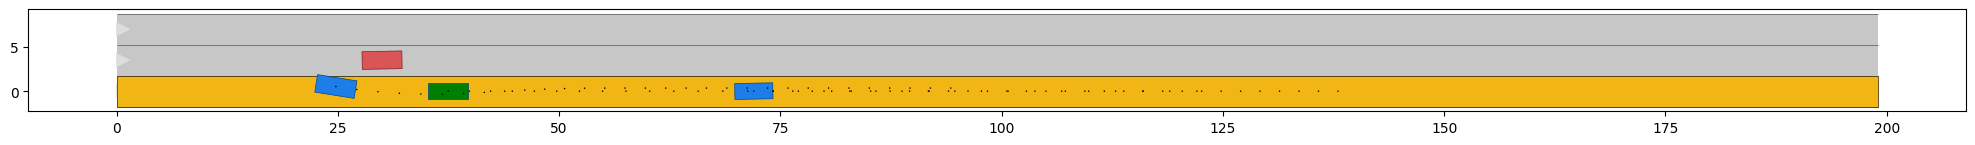

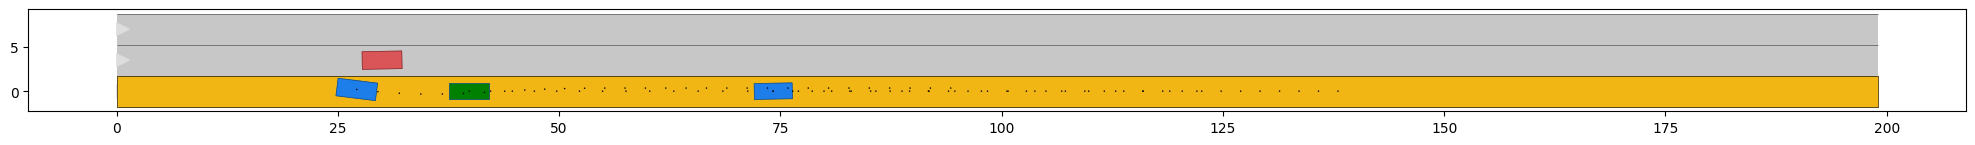

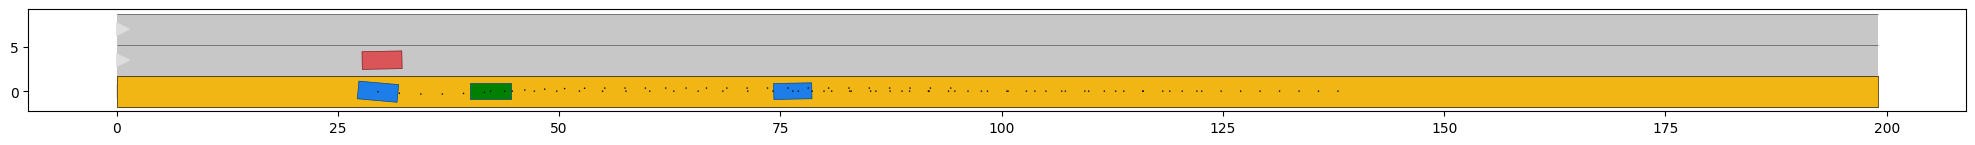

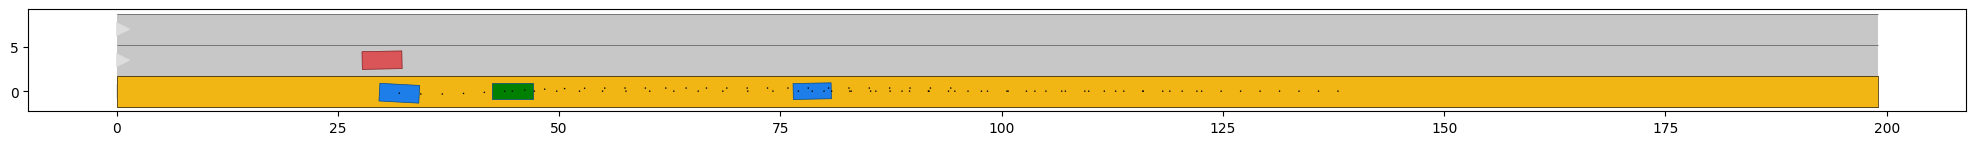

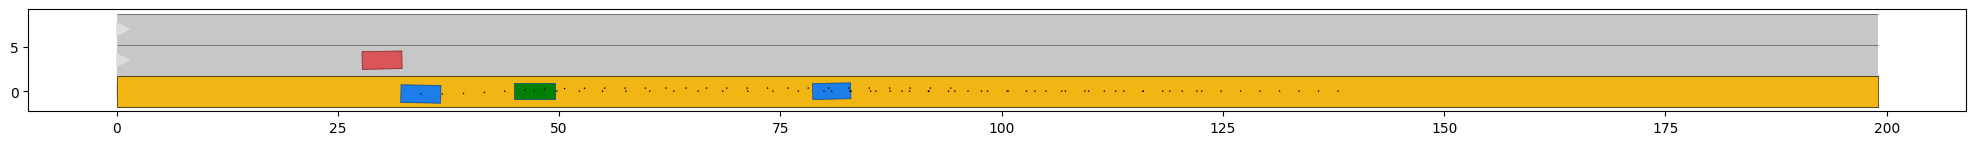

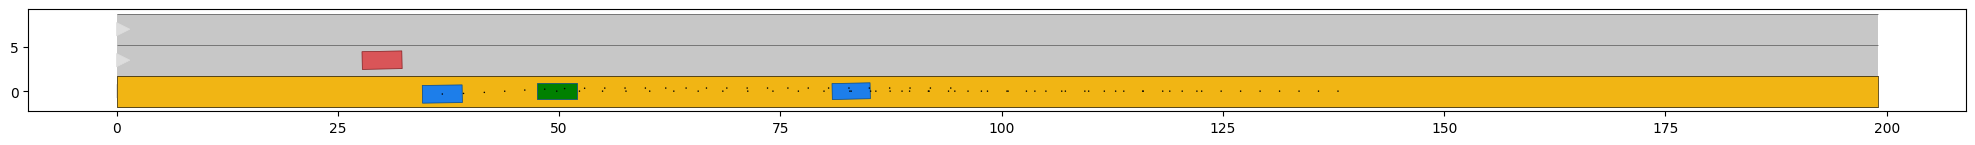

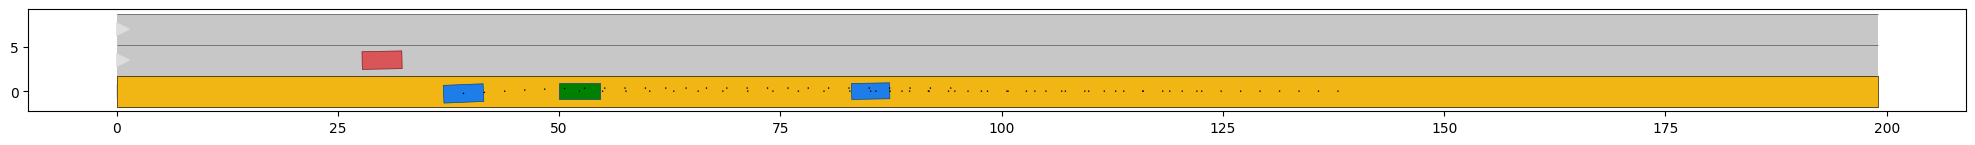

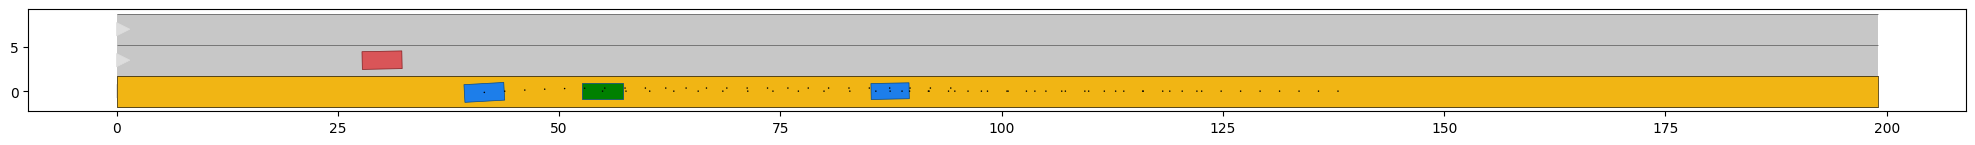

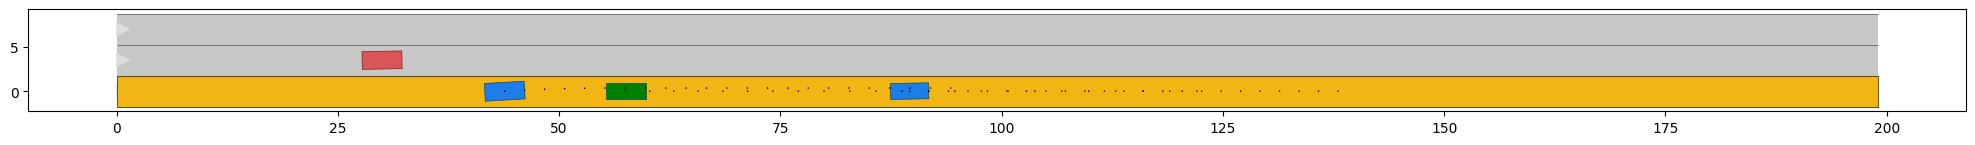

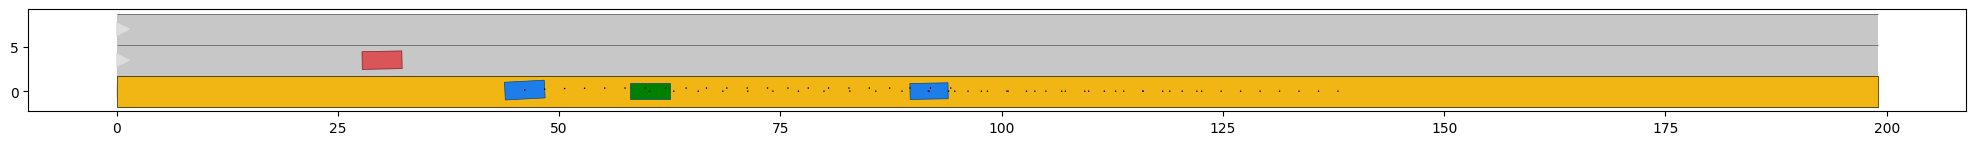

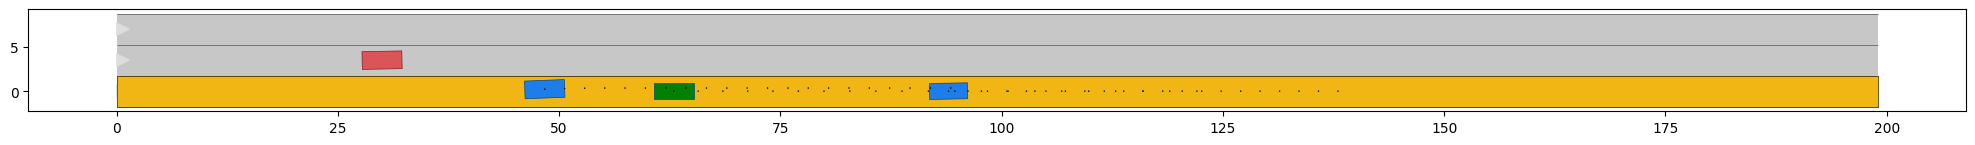

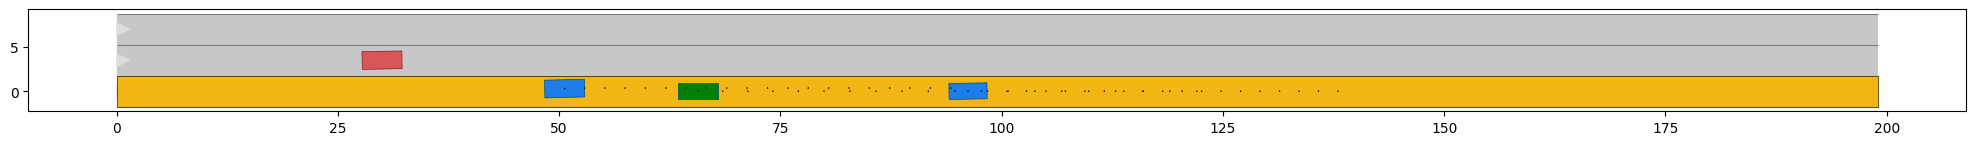

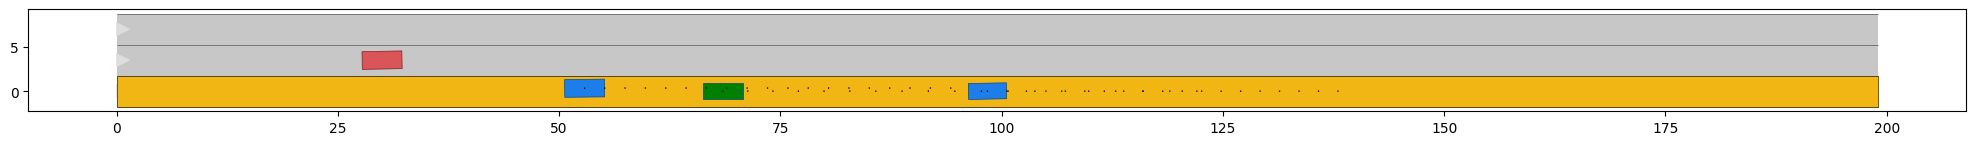

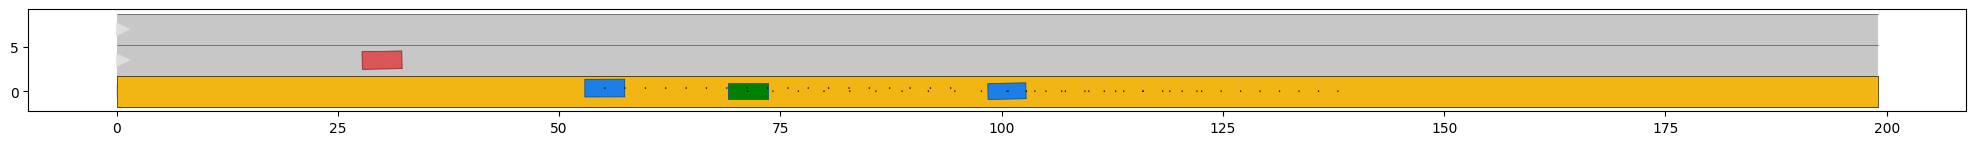

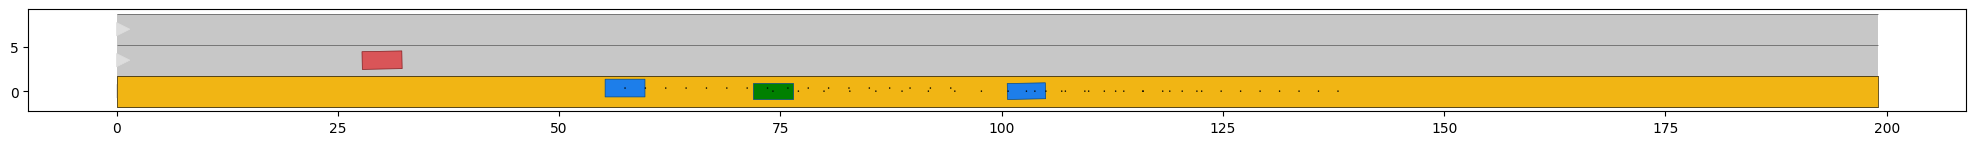

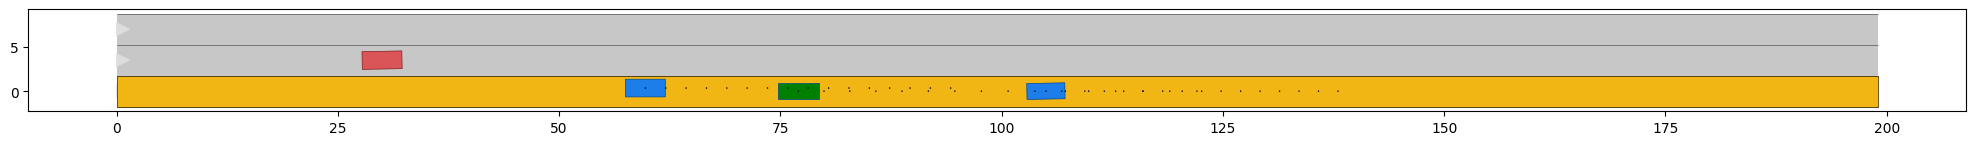

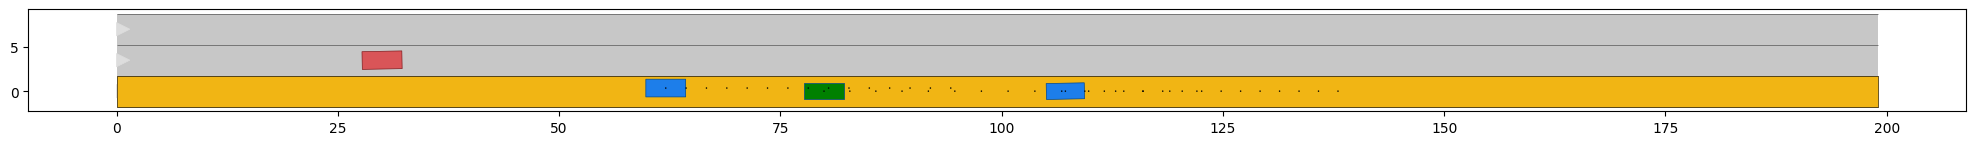

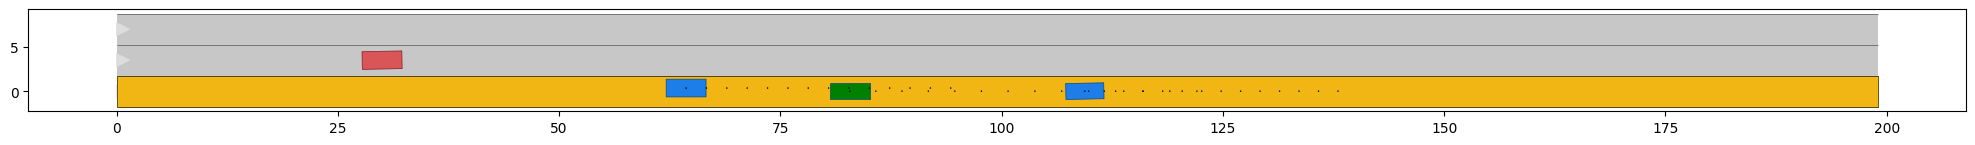

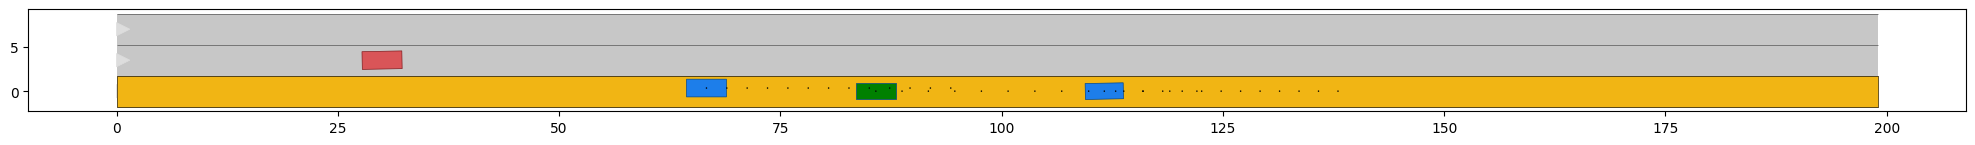

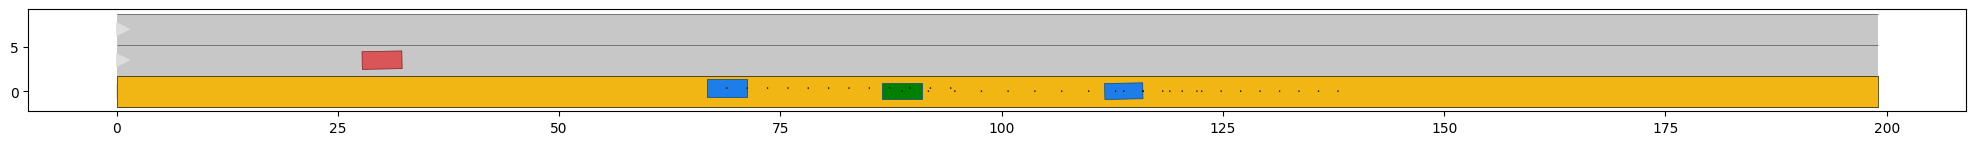

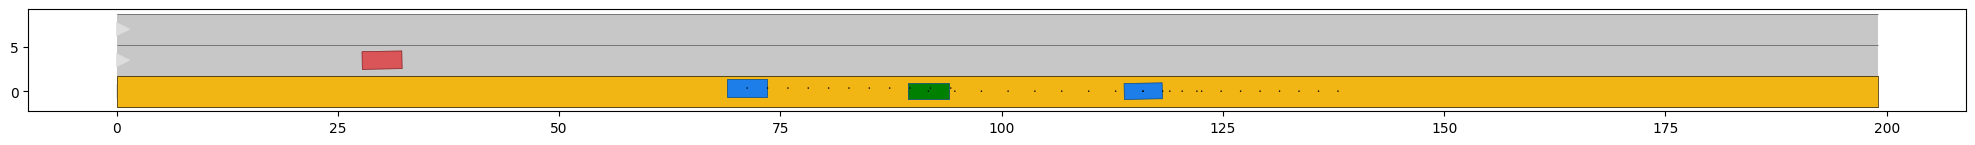

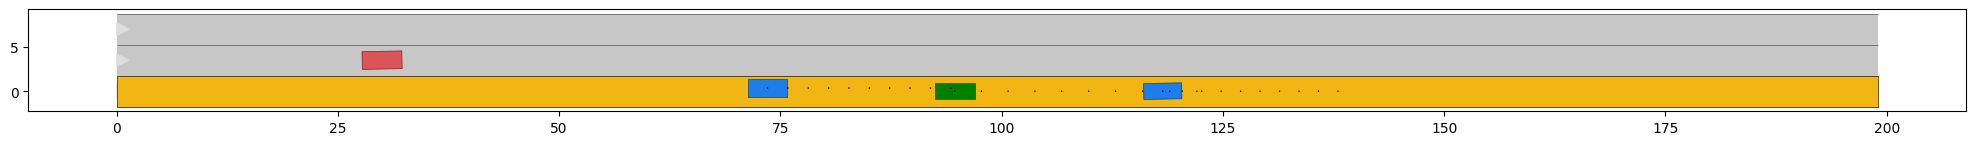

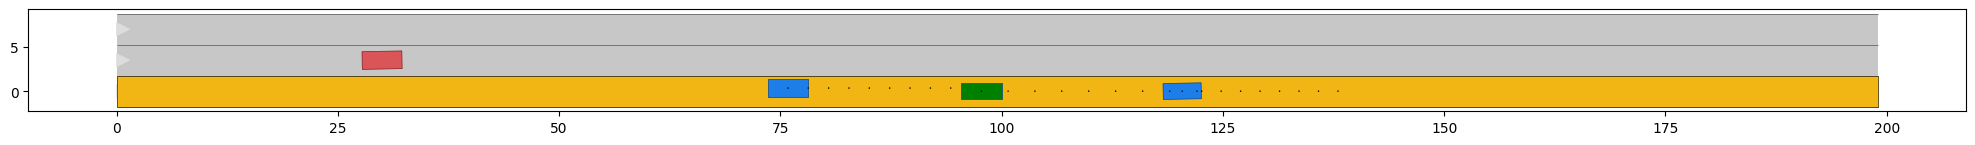

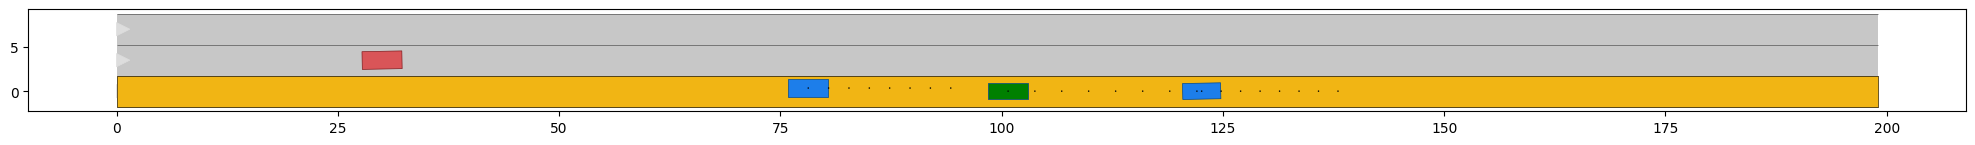

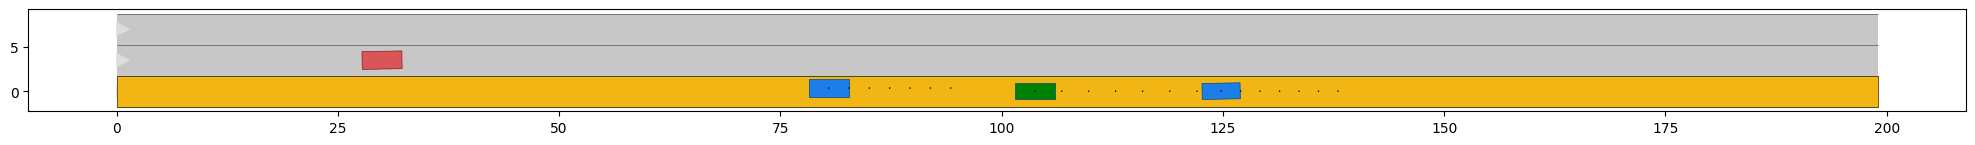

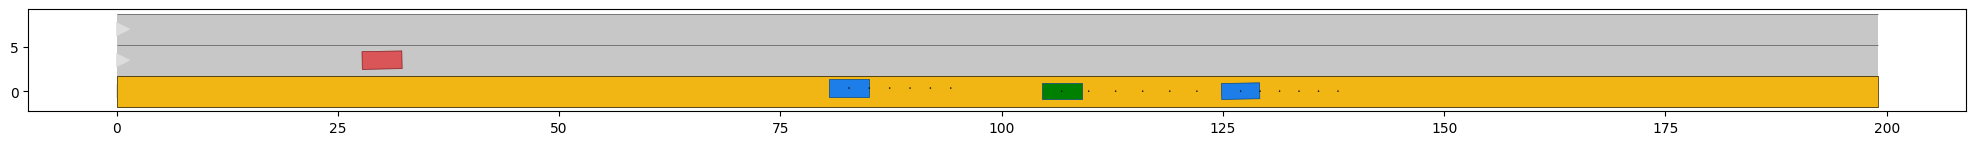

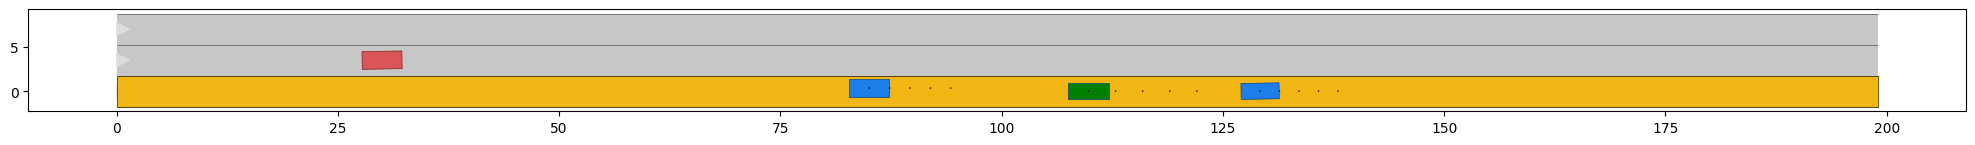

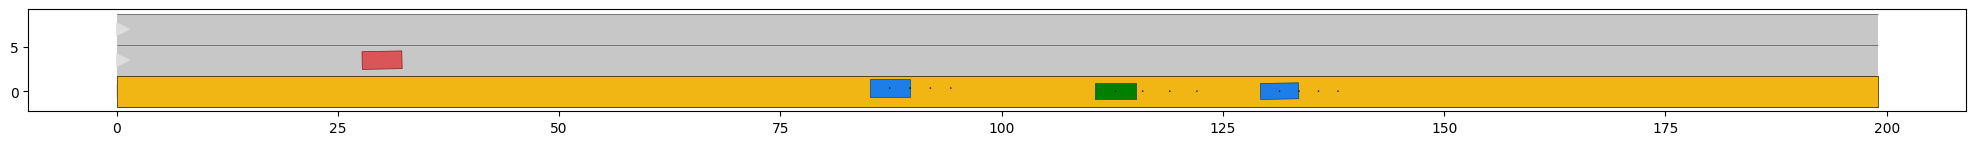

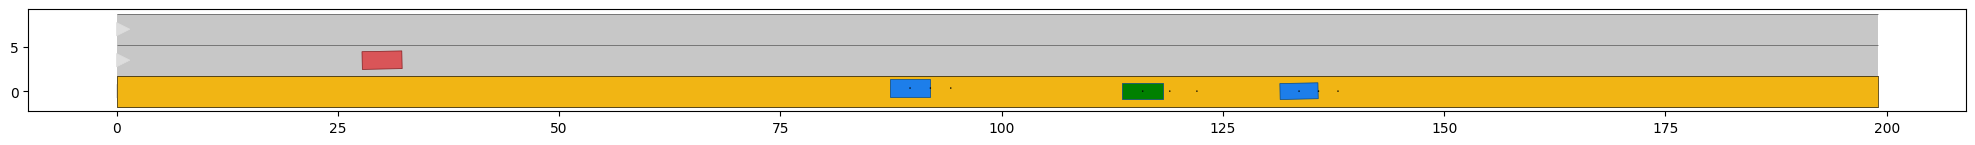

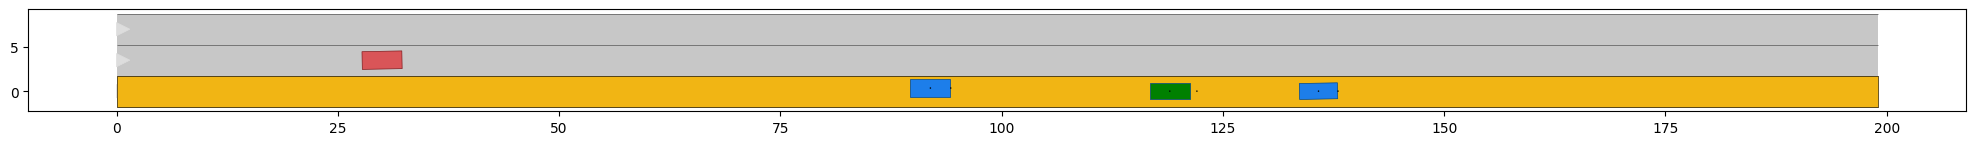

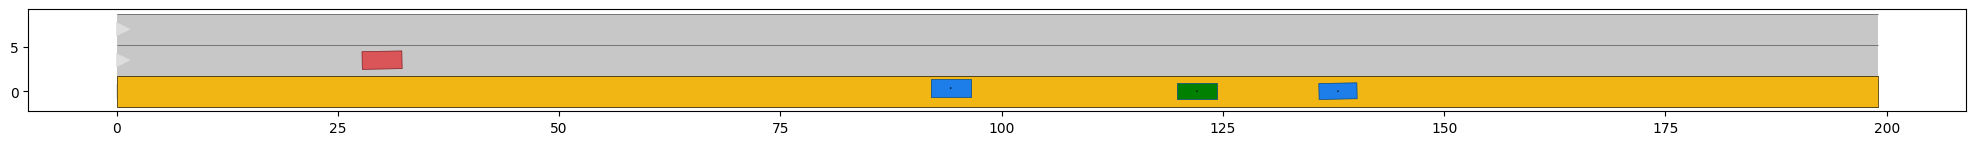

In [15]:
# convert planned trajectory to use point-mass states to include lateral velocity
orientation = (
    planning_problem.initial_state.orientation
)  # assume the ego vehicle keeps its orientation from the initial state
state_list = [
    PMState(
        time_step=s.time_step,
        position=np.array([s.longitudinal_position, 0]),
        velocity=s.velocity * np.cos(orientation),
        velocity_y=s.velocity * np.sin(orientation),
    )
    for s in trajectory.state_list
]
ego_vehicle_trajectory = Trajectory(initial_time_step=1, state_list=state_list)

# create the prediction using the planned trajectory and the shape of the ego vehicle
vehicle3 = parameters_vehicle3.parameters_vehicle3()
ego_vehicle_shape = Rectangle(length=vehicle3.l, width=vehicle3.w)
ego_vehicle_prediction = TrajectoryPrediction(
    trajectory=ego_vehicle_trajectory, shape=ego_vehicle_shape
)

# the ego vehicle can be visualized by converting it into a DynamicObstacle
ego_vehicle_type = ObstacleType.CAR
ego_vehicle = DynamicObstacle(
    obstacle_id=100,
    obstacle_type=ego_vehicle_type,
    obstacle_shape=ego_vehicle_shape,
    initial_state=planning_problem.initial_state,
    prediction=ego_vehicle_prediction,
)

# plot the scenario and the ego vehicle for each time step
ego_params = DynamicObstacleParams()
ego_params.vehicle_shape.occupancy.shape.facecolor = "g"
for i in range(0, time_steps + 1):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    rnd.draw_params.time_begin = i
    scenario.draw(rnd)
    ego_params.time_begin = i
    ego_vehicle.draw(rnd, draw_params=ego_params)
    planning_problem_set.draw(rnd)
    rnd.render()

# Exercise 6

Now that we have the planned trajectory and motion of our vehicle, we are ready to write the scenario to a benchmark solution file. This can be done by using the Solution Writer provided by Commonroad.
A solution file requires a trajectory for the planning problem and IDs for vehicle model, vehicle type, and the scenario ID.
Remember, we used a point-mass vehicle model (`PM`) and the parameters for VW_VANAGON (vehicle type 3). For the cost function, we choose `WX1` (see <a href="https://gitlab.lrz.de/tum-cps/commonroad-cost-functions/blob/master/costFunctions_commonRoad.pdf">documentation</a>).

After running the following code, you will find a file automatically named in the following format according to the definition from our <a href="http://mediatum.ub.tum.de/doc/1379638/776321.pdf">paper</a>:

`solution_`{<a href="https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/blob/master/vehicleModels_commonRoad.pdf">VehicleModel&VehicleType</a>}:{<a href="https://gitlab.lrz.de/tum-cps/commonroad-cost-functions/blob/master/costFunctions_commonRoad.pdf">CostFunctionID</a>}:{<a href="https://commonroad.in.tum.de/scenarios/">scenario_id</a>}:{`ScenarioVersion`}`.xml`

In this case, the file will be named `solution_PM3:SM3:ZAM_Tutorial-1_2_T-1:2020a.xml` and it is ready to be submitted on the submissions page.

In [16]:
from commonroad.common.solution import (
    CommonRoadSolutionWriter,
    CostFunction,
    PlanningProblemSolution,
    Solution,
    VehicleModel,
    VehicleType,
)

pps = PlanningProblemSolution(
    planning_problem_id=100,
    vehicle_type=VehicleType.VW_VANAGON,
    vehicle_model=VehicleModel.PM,
    cost_function=CostFunction.WX1,
    trajectory=ego_vehicle_prediction.trajectory,
)

# define the object with necessary attributes.
solution = Solution(scenario.scenario_id, [pps], computation_time=planner.last_computation_time)

# write solution to a xml file
csw = CommonRoadSolutionWriter(solution)
csw.write_to_file(overwrite=True)

# Exercise 7

To submit the CommonRoad solution, you need to create an account and afterwards a submission <a href="https://commonroad.in.tum.de/new-submission">here</a>.

Select the file generated in the previous step and submit your solution.
After uploading, you can check your score before publishing your solution.

Finally, you can compare your result against others in the <a href="https://commonroad.in.tum.de/solutions/ranking">ranking</a>!